### Summary
Quick and dirty GDP growth comparisons between Brazil and other countries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

#pd.set_option('display.max_rows', 150)
#pd.set_option('display.min_rows', 65)
pd.set_option('display.max_columns', None)

In [2]:
df_base = pd.read_csv("..\DataSets\economicData_1960-2022_noNaN-drops.csv")


df_base = df_base[['Country Name', 'Index Year', 'GDP per capita (current USD)', 'Country Quintile']]
df_base.rename(columns={'GDP per capita (current USD)': 'GDP_perCapita'}, inplace=True)


# Calculating GDP per capita growth
df_base.sort_values(['Country Name', 'Index Year'], inplace=True)
df_base['GDP_perCapita_growth'] = df_base.groupby('Country Name')['GDP_perCapita'].pct_change()
df_base['GDP_perCapita_growth'].fillna(0, inplace=True)

# Defining GroupSets
We'll define groups to compare Brazil against:
- LatAm
- BRICS
- G20
- MidUpperIncome (3rd & 4th quintiles)


In [3]:
LatAm = [
    "Argentina",
    "Bolivia",
    "Brazil",
    "Chile",
    "Colombia",
    "Costa Rica",
    "Cuba",
    "Dominican Republic",
    "Ecuador",
    "El Salvador",
    "Guatemala",
    "Haiti",
    "Honduras",
    "Mexico",
    "Nicaragua",
    "Panama",
    "Paraguay",
    "Peru",
    "Uruguay",
    "Venezuela"
]


BRICS = [
    "Brazil",
    "Russia",
    "India",
    "China",
    "South Africa"
]

G20 = [
    "Argentina",
    "Australia",
    "Brazil",
    "Canada",
    "China",
    "France",
    "Germany",
    "India",
    "Indonesia",
    "Italy",
    "Japan",
    "Mexico",
    "Russia",
    "Saudi Arabia",
    "South Africa",
    "South Korea",
    "Turkey",
    "United Kingdom",
    "United States"
]

# Calculate the mode (most common value) for 'Country Quintile' for each country
df_base['Country Quintile'] = df_base.groupby('Country Name')['Country Quintile']\
                                .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)


# Selecting any country that appear in Q3 and Q4
MidUpperIncome = list(df_base[(df_base['Country Quintile'] == 'Q3')\
                              | (df_base['Country Quintile'] == 'Q4')]['Country Name'].unique())

### Defining functions to make our work less repetitive

In [4]:
def plotRank(df_base, group, groupName):
    df_group = df_base[df_base['Country Name'].isin(group)].copy()


    # Rank GDP_perCapita within each year
    df_group['GDP_rank'] = df_group.groupby('Index Year')['GDP_perCapita_growth'].rank(ascending=False, method='min')


    # Subset the dataframe for Brazil
    df_Brazil = df_group[df_group['Country Name'] == 'Brazil']

    # Plot using seaborn
    plt.figure(figsize=(15,6))
    sns.lineplot(x='Index Year', y='GDP_rank', data=df_Brazil)

    # Calculate the median rank for Brazil
    brazil_median_rank = df_Brazil['GDP_rank'].median()

    # ---- Annotate the median value on the plot
    
    plt.annotate(f'Median Rank: {brazil_median_rank}', xy=(df_Brazil['Index Year'].median(), brazil_median_rank), 
                 xytext=(df_Brazil['Index Year'].median() - 5, brazil_median_rank * 1.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5'))

    plt.gca().invert_yaxis() # Invert y axis
    plt.title(f'Brazil GDP per Capita growth ranking, as compared to {groupName}')
    plt.show()


In [5]:
# Define a function to format y-axis ticks as percentages
def percentage_formatter(x, pos):
    return f"{100 * x:.1f}%"

def plotGrowthByYear(df_base, group, groupName, yScale = 1.5, alpha = 0.15):  
    df_group = df_base[df_base['Country Name'].isin(group)].copy()
    
    # Removing both the first and last years (since they have no growth)
    df_base = df_base[(df_base['Index Year'] > 1960) & (df_base['Index Year'] < 2022)]    

    # Highlighting Brazil from other countries
    df_group['highlight'] = df_group['Country Name'] == 'Brazil'    
    
    # ---------- Plotting Begins
    plt.figure(figsize=(25, 8))

    for country in df_group['Country Name'].unique():
        if country != 'Brazil':
            sns.lineplot(x='Index Year', y='GDP_perCapita_growth', data=df_group[df_group['Country Name'] == country], 
                         color='blue', alpha=alpha, legend=False)

    # Make Brazil's line more visible
    sns.lineplot(x='Index Year', y='GDP_perCapita_growth', data=df_group[df_group['Country Name'] == 'Brazil'], 
                 color='Green', label='Brazil')

    # Setting the x-axis division to be every 4 years
    start_year = df_group['Index Year'].min()
    end_year = df_group['Index Year'].max()
    plt.xticks(np.arange(start_year-2, end_year + 1, 4))


    # Add percentage styling to the y-axis
    plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    
    
    plt.title(f"{groupName}'s GDP per Capita Growth (Highlighting Brazil)")
    plt.ylabel('GDP per Capita Growth (in constant USD)')
    plt.xlabel('Index Year')
    plt.legend(loc='upper left')
    
    # Find maximum and minimum growth
    maxValue = df_group[df_group['Country Name'] == 'Brazil']['GDP_perCapita_growth'].max() * yScale
    minValue = df_group[df_group['Country Name'] == 'Brazil']['GDP_perCapita_growth'].min() * yScale
    plt.ylim(minValue,maxValue)
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

In [6]:
def plotCumulativeGrowth(df_base, group, groupName, periodStart, periodEnd, yScale = 1.05, alpha = 0.15, xOffSet = -2):
    df_group = df_base[df_base['Country Name'].isin(group)].copy()
    
    # Selecting year range
    df_group = df_group[(df_group['Index Year'] >= periodStart) & (df_group['Index Year'] <= periodEnd)]
    
    # Highlighting Brazil from other countries
    df_group['highlight'] = df_group['Country Name'] == 'Brazil'
    
    # Setting first value as zero (so every country starts at the same place)
    df_group.loc[df_group['Index Year'] == periodStart, 'GDP_perCapita_growth'] = 0
    
    # Cumulative calculation
    df_group['CumulativeGDP'] = (1 + df_group['GDP_perCapita_growth']).groupby(df_group['Country Name']).cumprod()
    
    # ---------- Plotting Begins
    plt.figure(figsize=(25, 8))

    for country in df_group['Country Name'].unique():
        if country != 'Brazil':
            sns.lineplot(x='Index Year', y='CumulativeGDP', data=df_group[df_group['Country Name'] == country], 
                         color='blue', alpha=alpha, legend=False)

    # Make Brazil's line more visible
    sns.lineplot(x='Index Year', y='CumulativeGDP', data=df_group[df_group['Country Name'] == 'Brazil'], 
                 color='Green', label='Brazil')

    # Setting the x-axis division to be every 4 years
    start_year = df_group['Index Year'].min()
    end_year = df_group['Index Year'].max()
    plt.xticks(np.arange(start_year+xOffSet, end_year + 1, 4))


    # Add percentage styling to the y-axis
    plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    
    
    plt.title(f"{groupName}'s cumulative GDP per capita growth from {periodStart} to {periodEnd} (Highlighting Brazil)")
    plt.ylabel('GDP per Capita Growth (in constant USD)')
    plt.xlabel('Index Year')
    plt.legend(loc='upper left')
    
    # Find maximum and minimum growth
    maxValue = df_group['CumulativeGDP'].max() * yScale
    minValue = df_group['CumulativeGDP'].min() * yScale
    plt.ylim(minValue,maxValue)
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

### Latin America

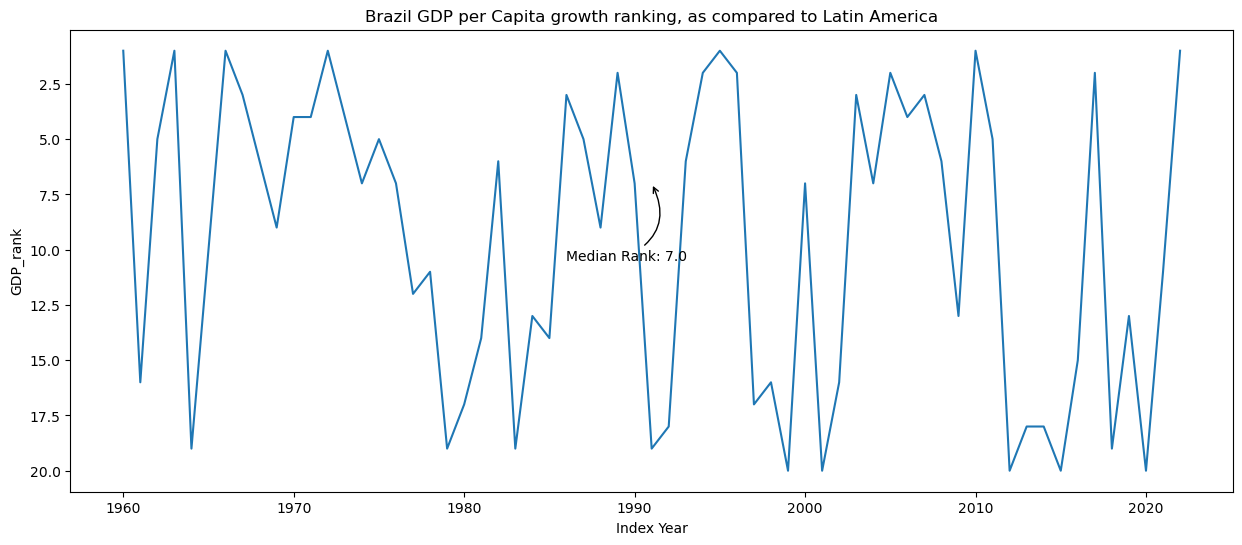

In [7]:
plotRank(df_base, LatAm, "Latin America")

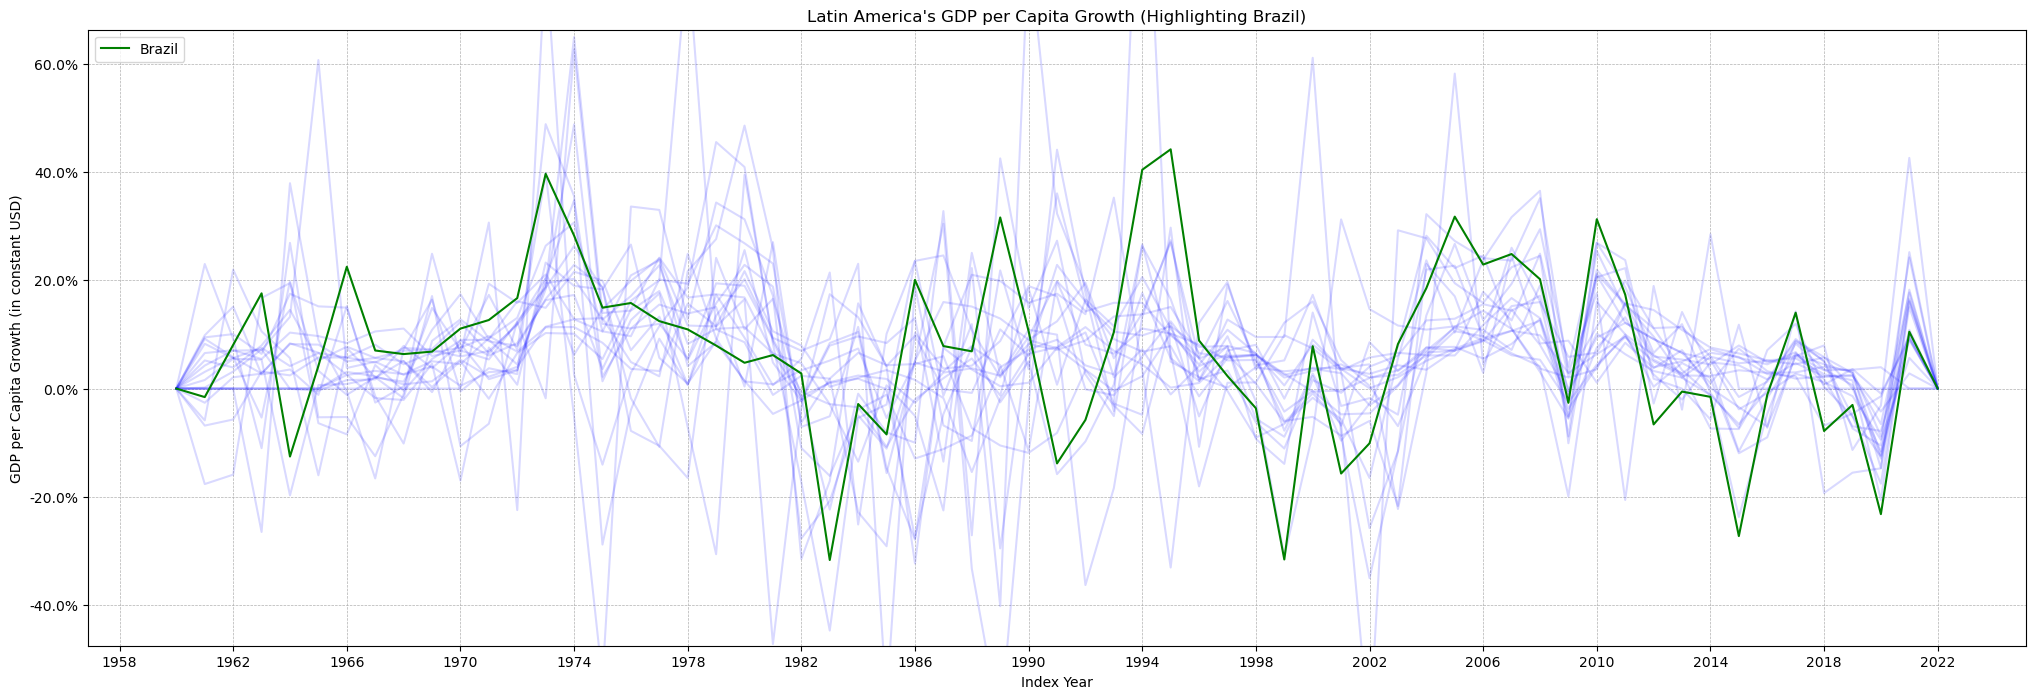

In [8]:
plotGrowthByYear(df_base, LatAm, "Latin America")

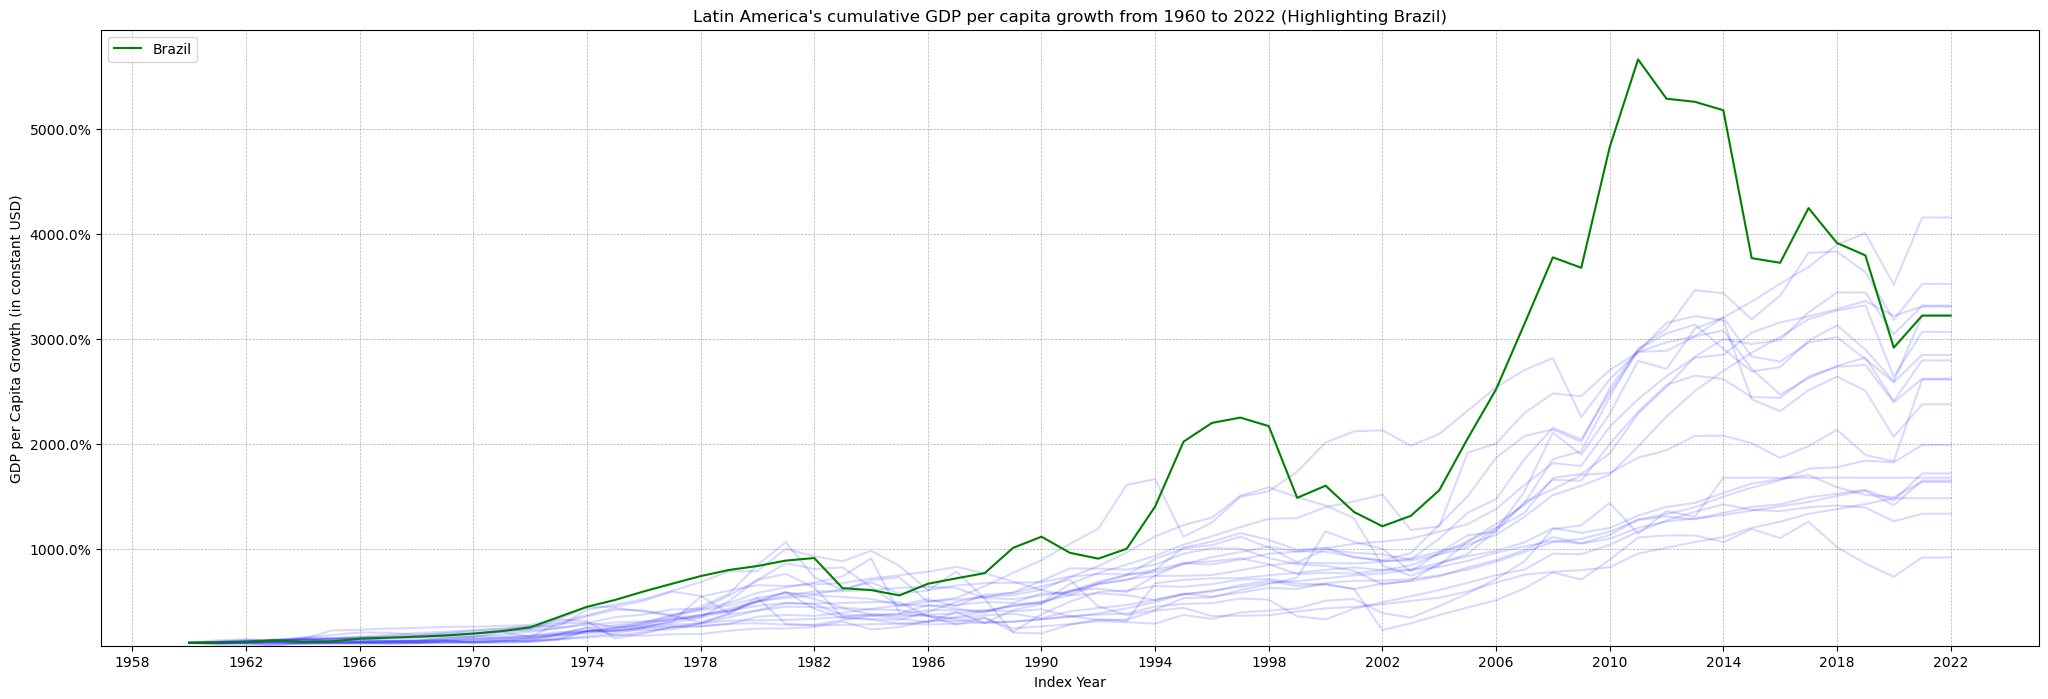

In [9]:
plotCumulativeGrowth(df_base, LatAm, "Latin America", 1960, 2022)

### BRICS

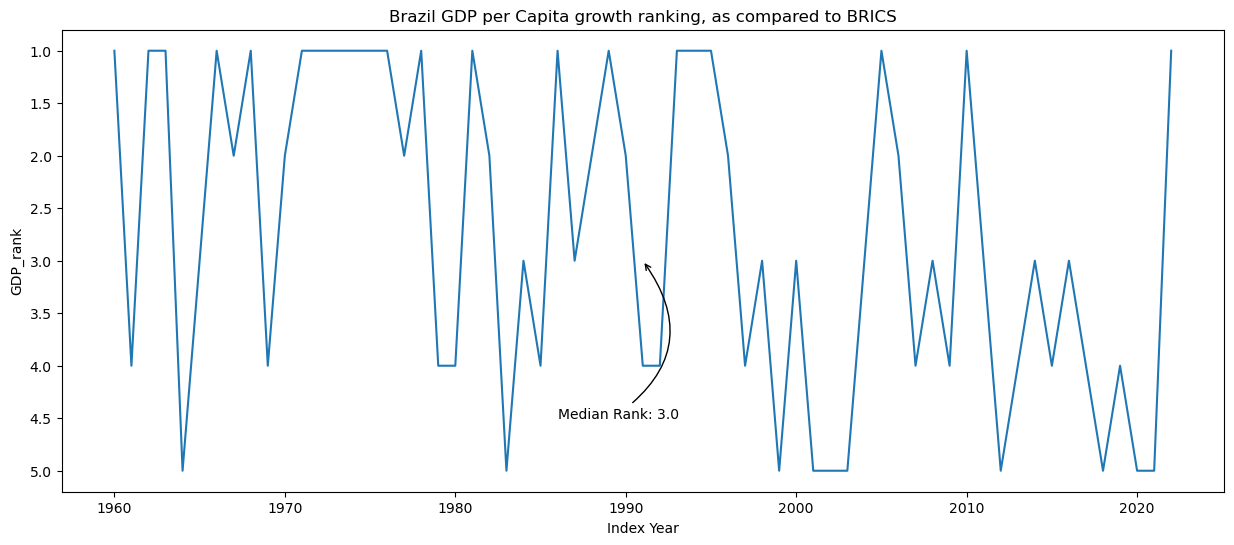

In [10]:
plotRank(df_base, BRICS, "BRICS")

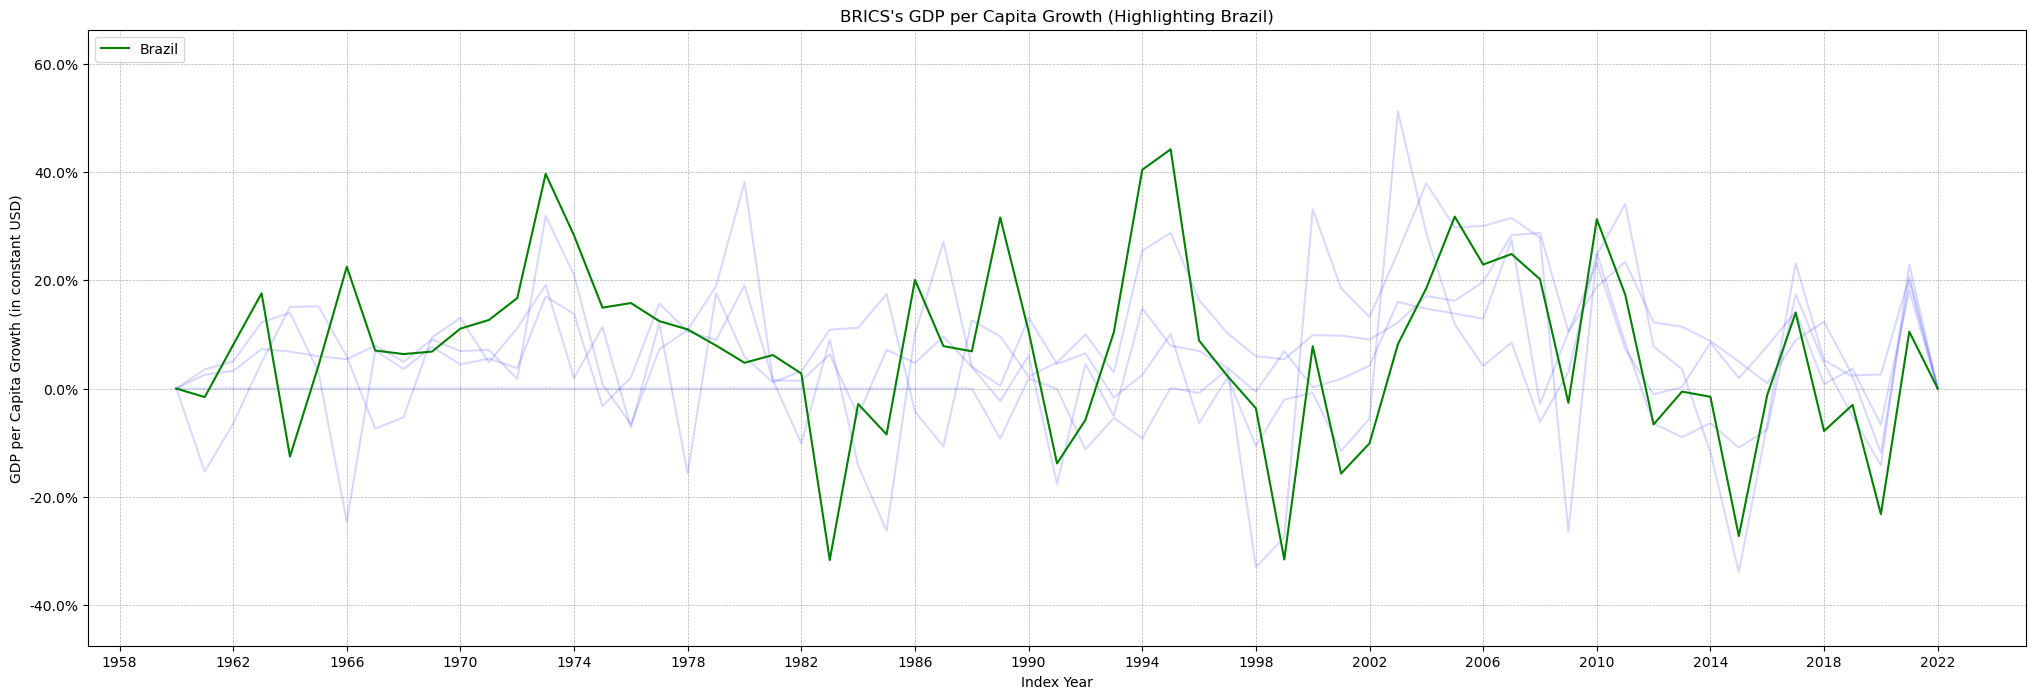

In [11]:
plotGrowthByYear(df_base, BRICS, "BRICS")

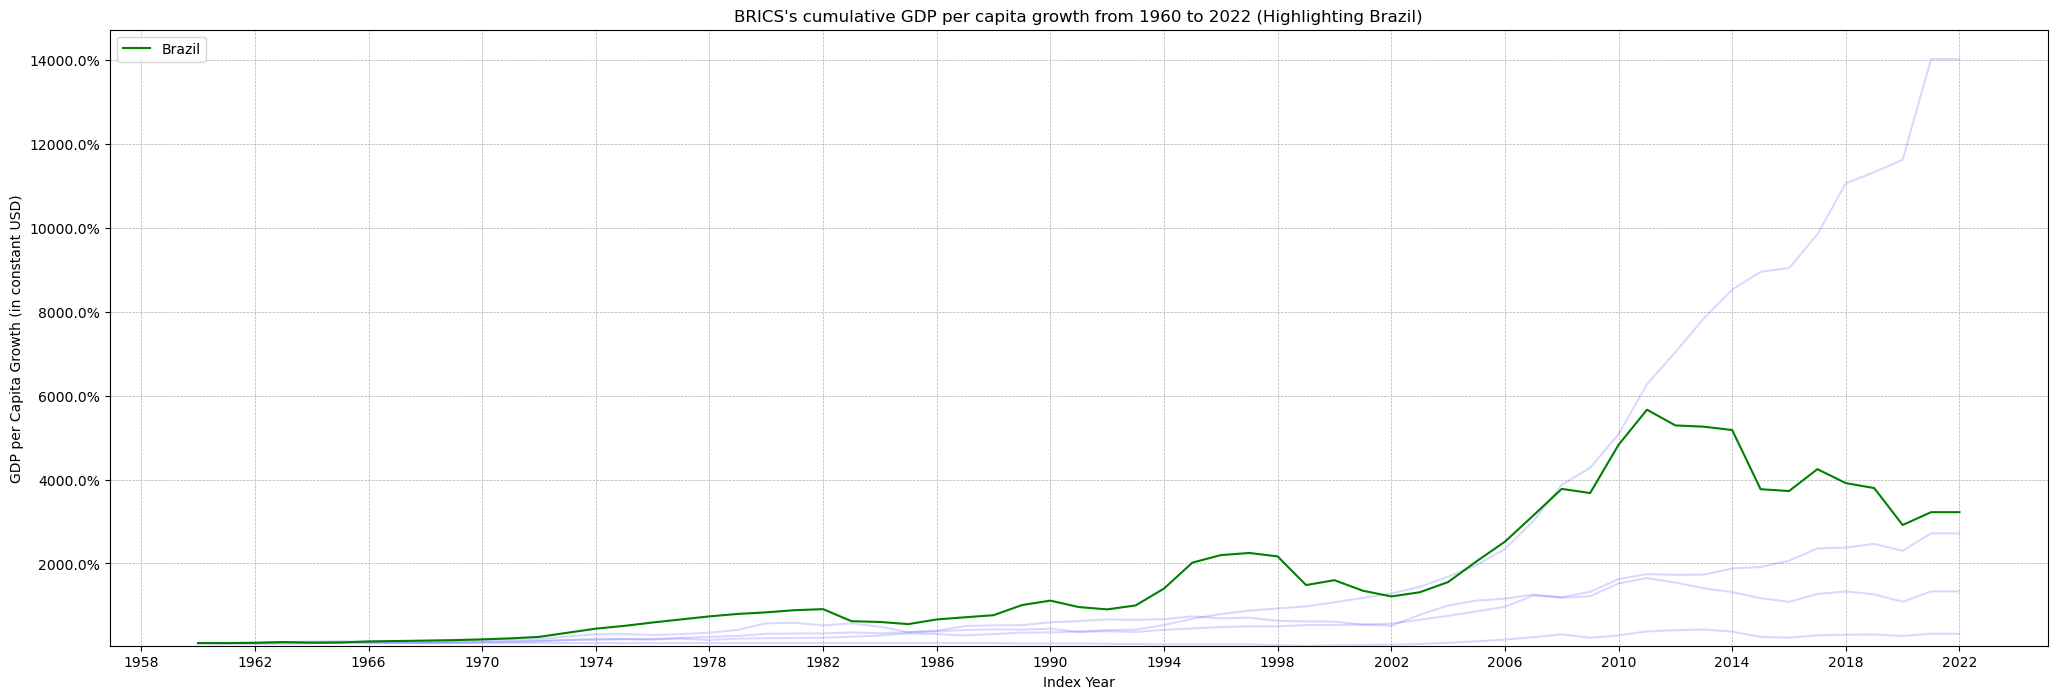

In [12]:
plotCumulativeGrowth(df_base, BRICS, "BRICS", 1960, 2022)

### G20

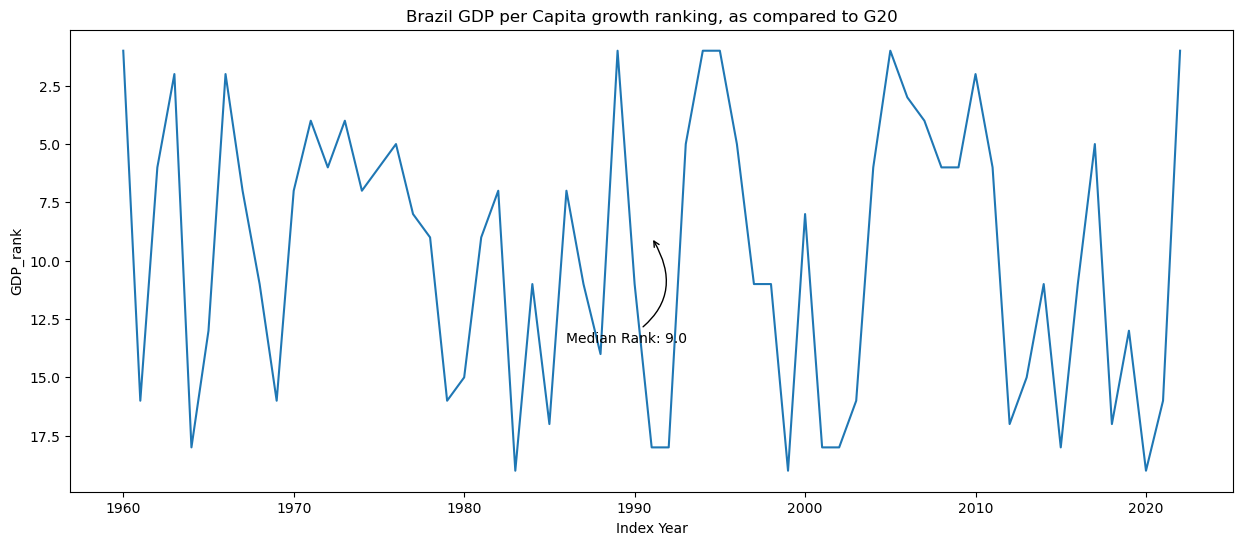

In [13]:
plotRank(df_base, G20, "G20")

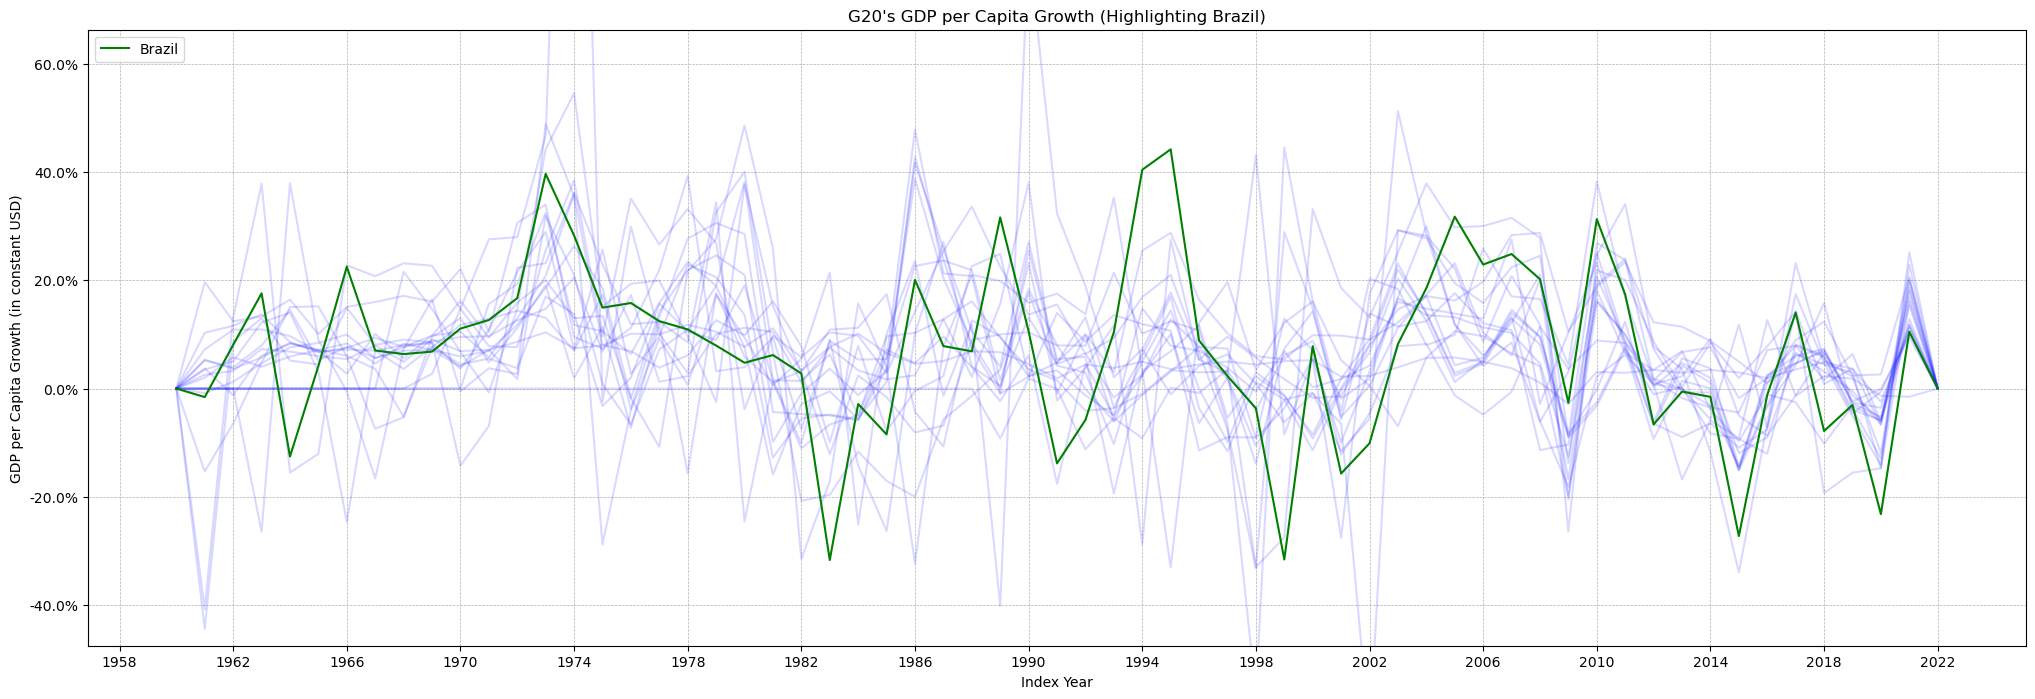

In [14]:
plotGrowthByYear(df_base, G20, "G20")

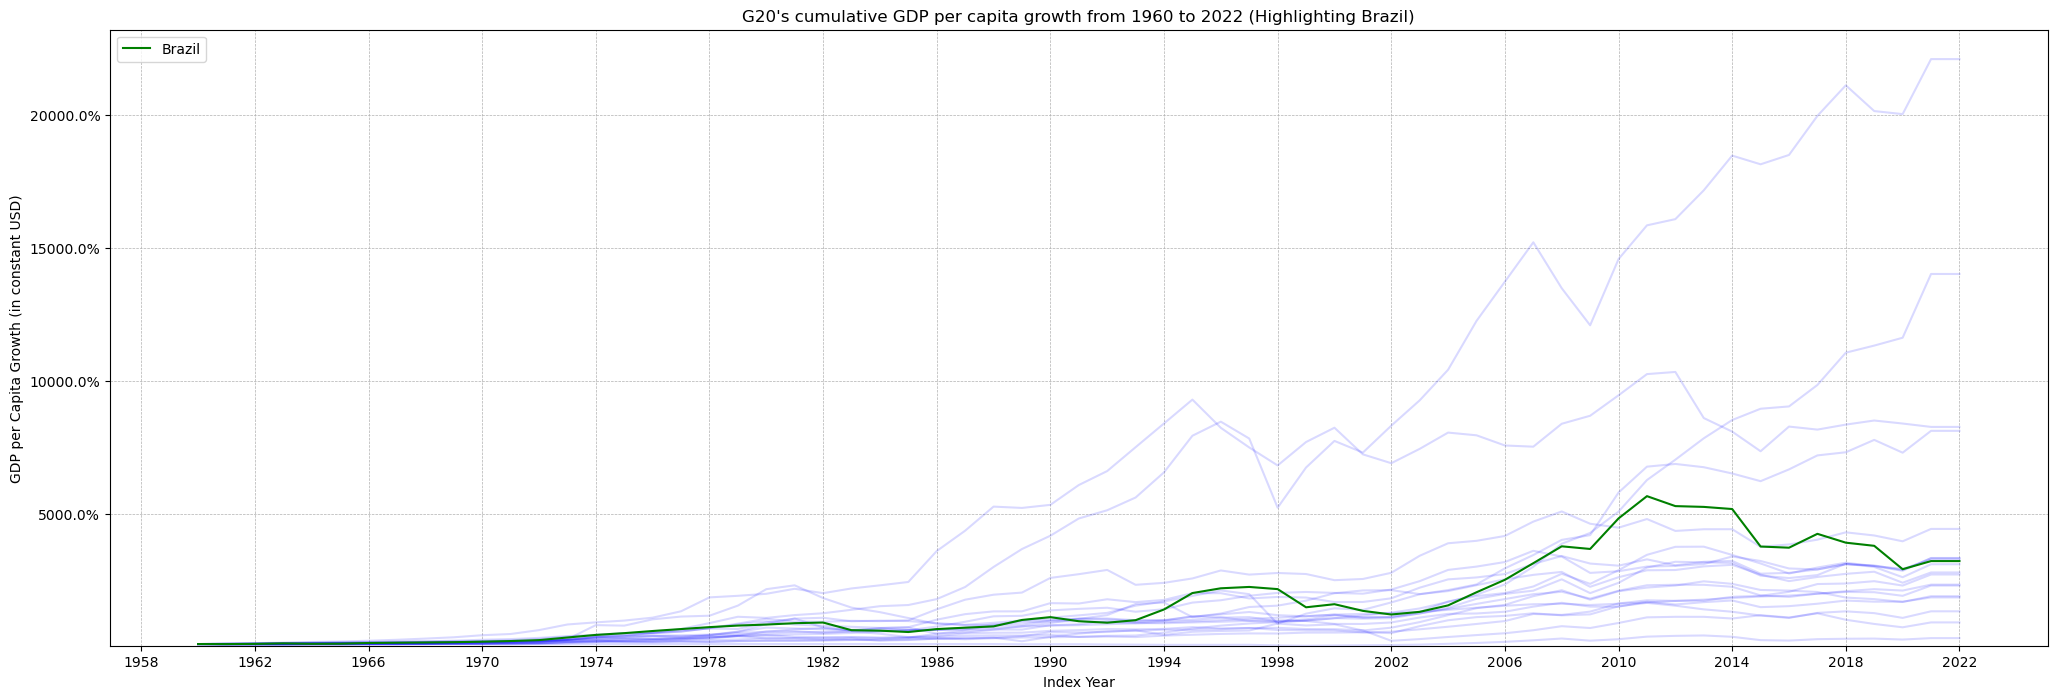

In [15]:
plotCumulativeGrowth(df_base, G20, "G20", 1960, 2022)

### Mid-Upper Income Countries

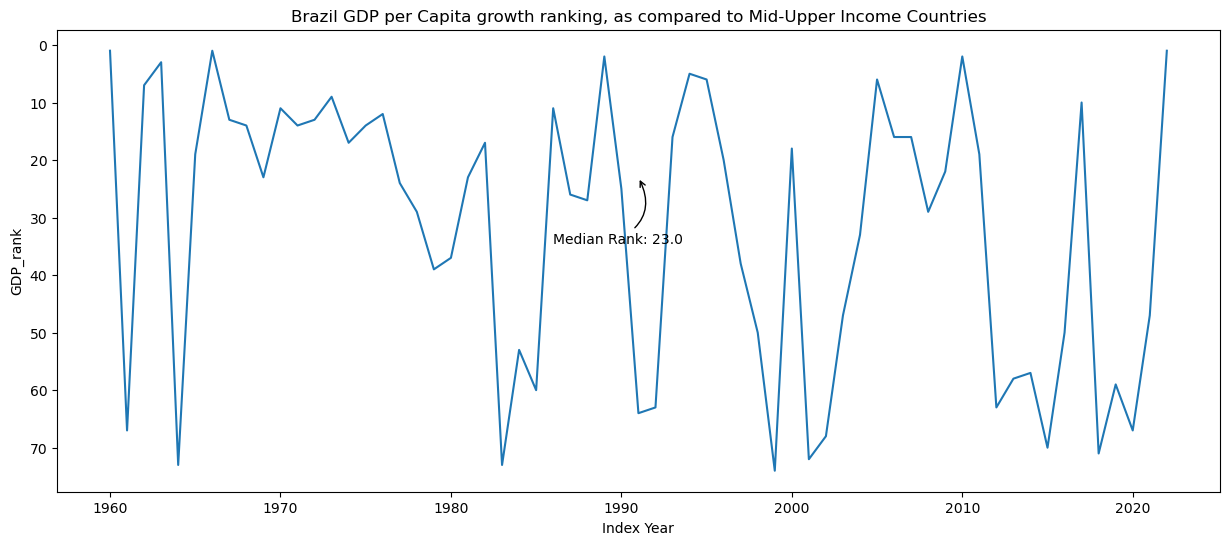

In [16]:
plotRank(df_base, MidUpperIncome, "Mid-Upper Income Countries")

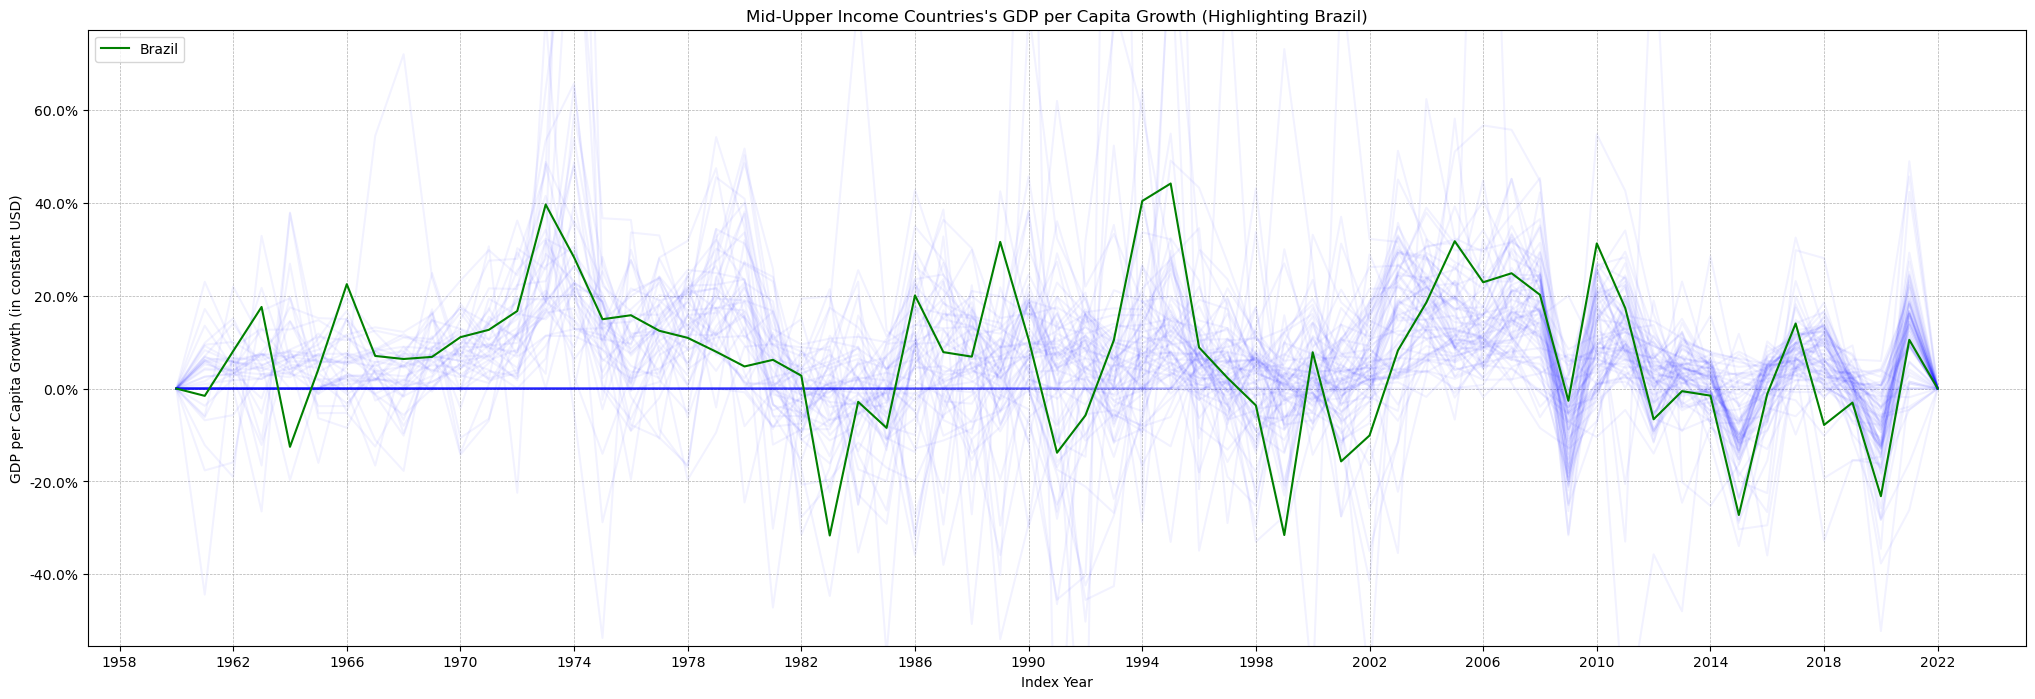

In [17]:
plotGrowthByYear(df_base, MidUpperIncome,"Mid-Upper Income Countries", yScale = 1.75, alpha = 0.05)

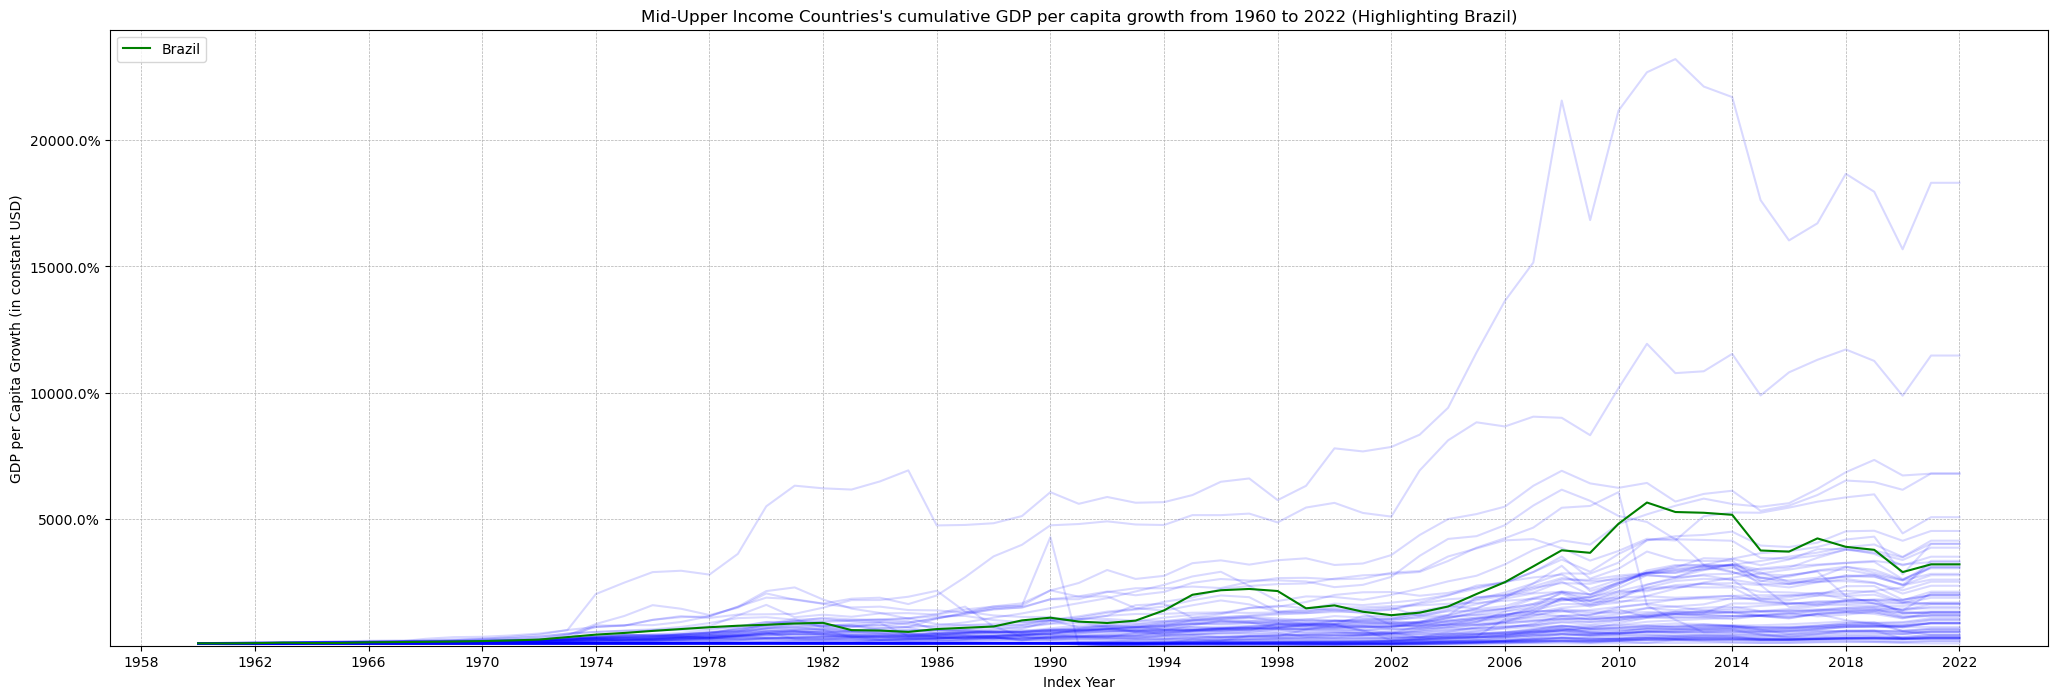

In [18]:
plotCumulativeGrowth(df_base, MidUpperIncome,"Mid-Upper Income Countries", 1960, 2022)

# Bonus Round
Let's plot cumulative growth for (almost) every president since 1960, using just MidUpperIncome and LatAm groups as comparison

### Military Dictatorship: 1964 ~1984

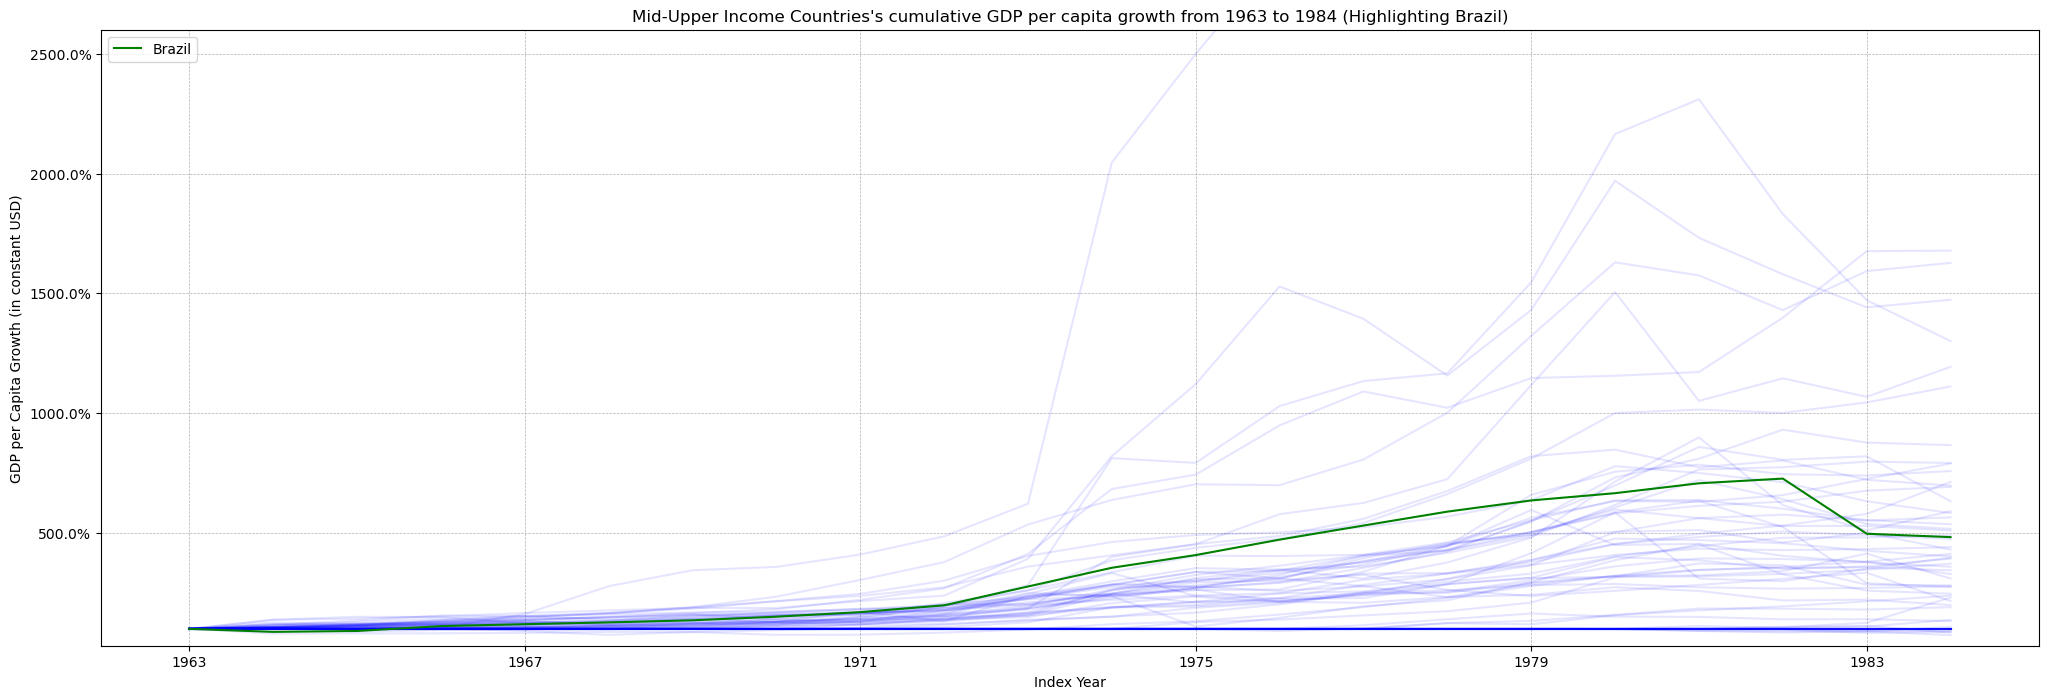

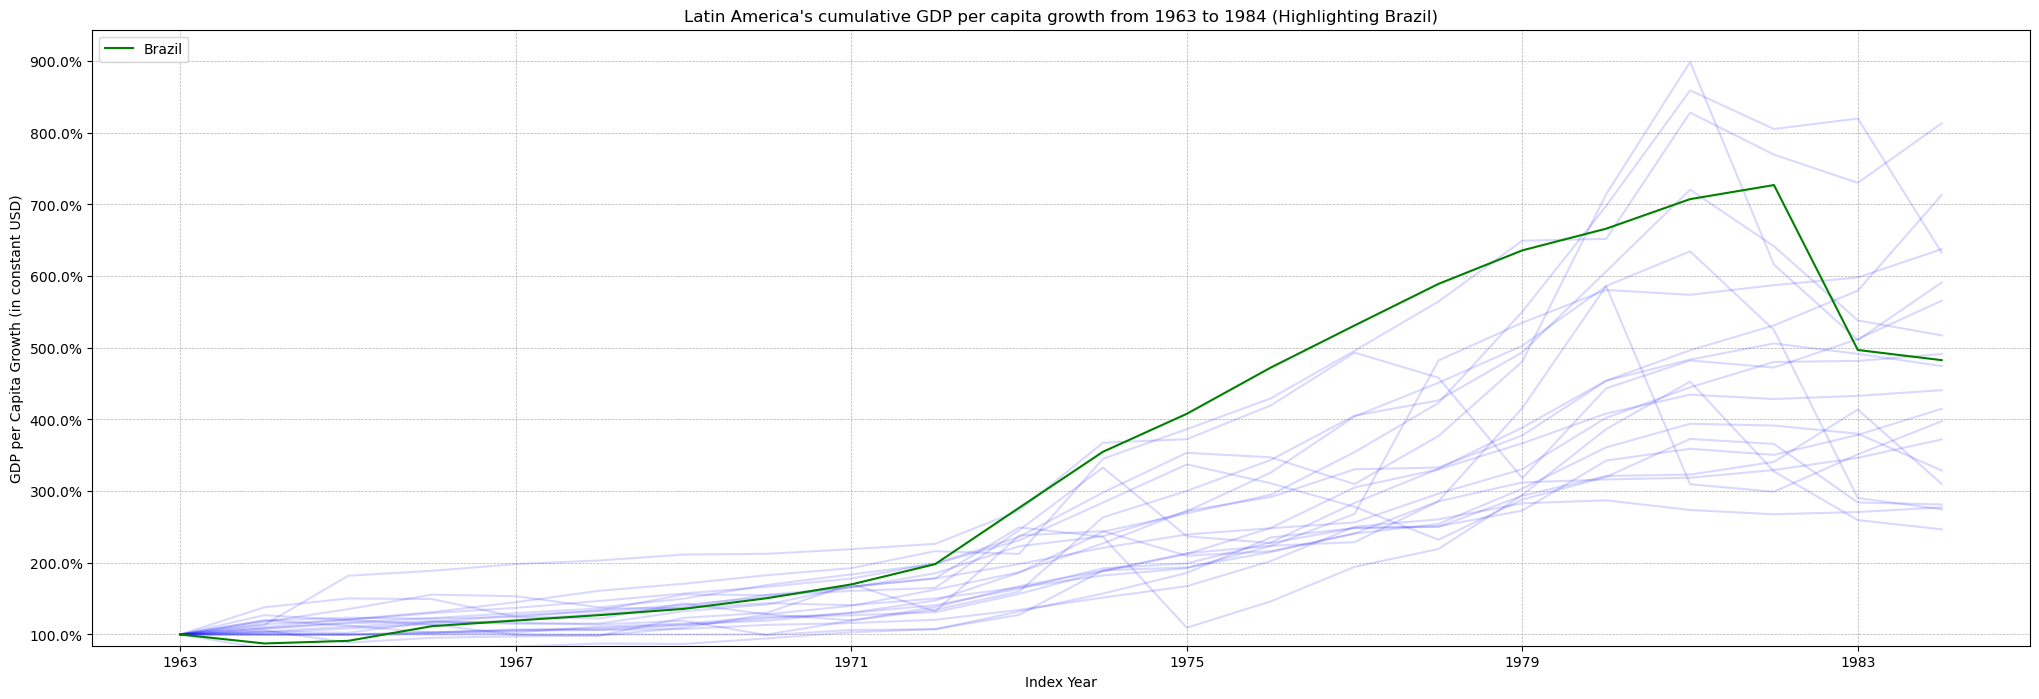

In [47]:
plotCumulativeGrowth(df_base, MidUpperIncome,"Mid-Upper Income Countries", 1963, 1984, xOffSet = 0, alpha = 0.1, yScale = 0.4)
plotCumulativeGrowth(df_base, LatAm, "Latin America", 1963, 1984, xOffSet = 0)

### José Sarney: 1985 ~1989

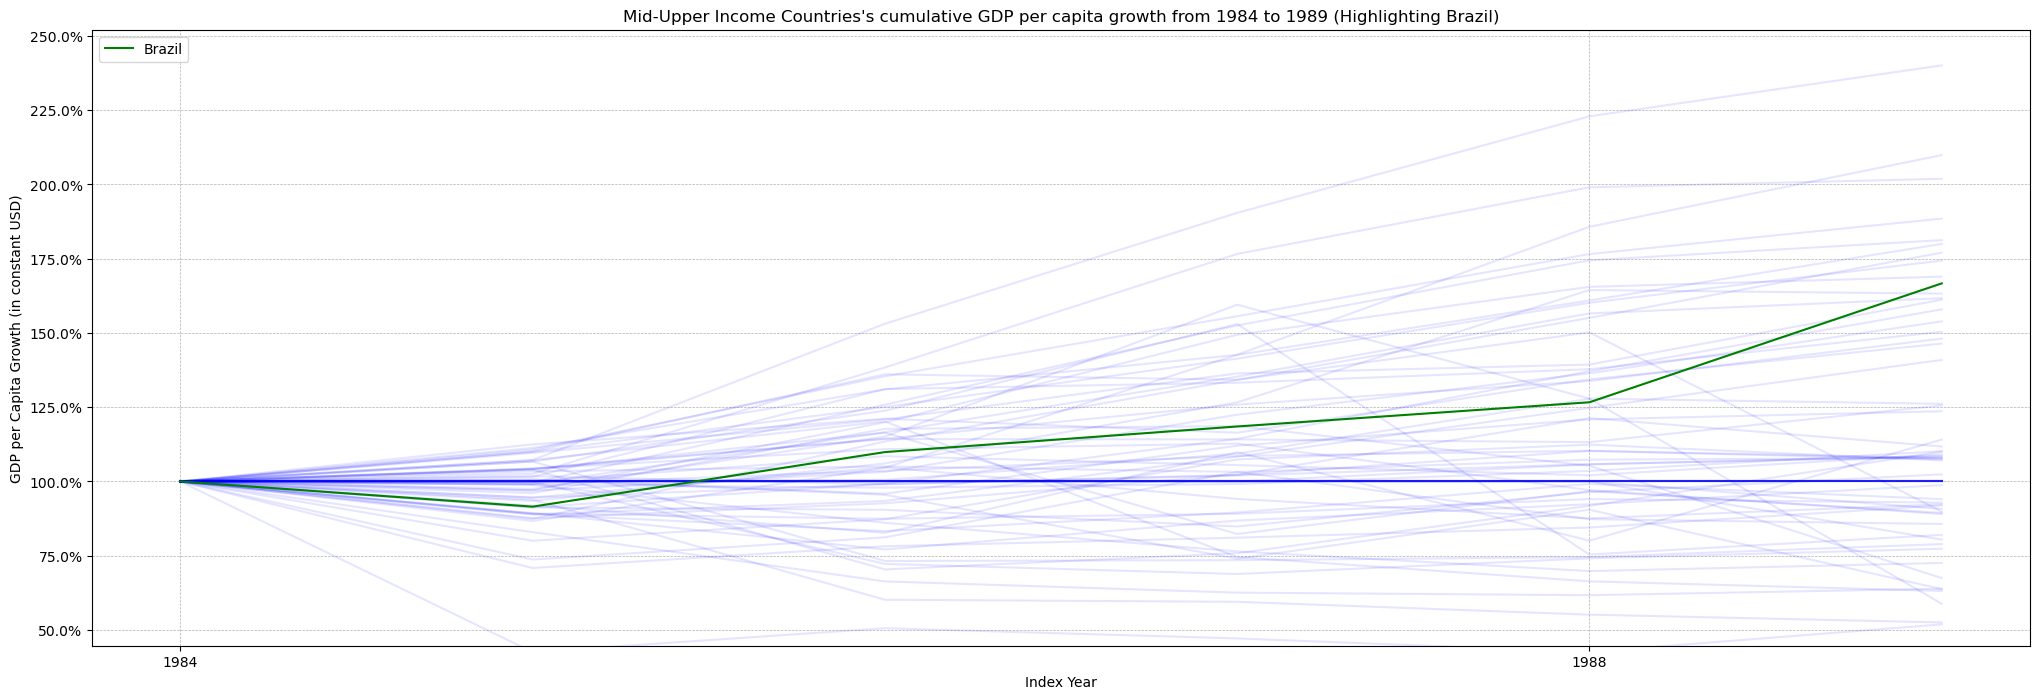

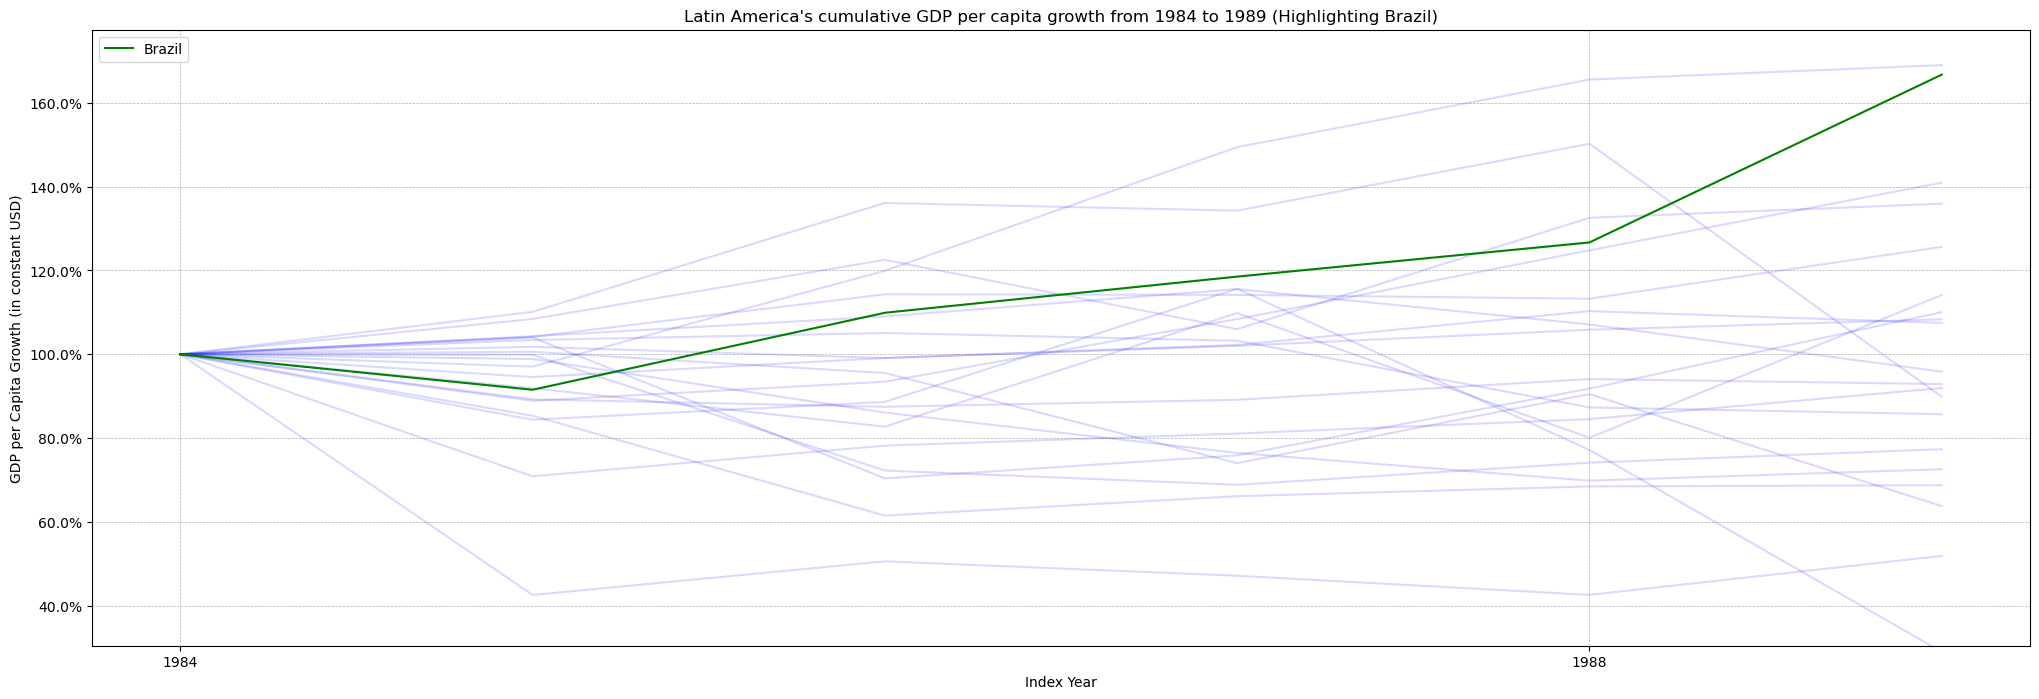

In [20]:
plotCumulativeGrowth(df_base, MidUpperIncome,"Mid-Upper Income Countries", 1984, 1989, xOffSet = 0, alpha = 0.1)
plotCumulativeGrowth(df_base, LatAm, "Latin America", 1984, 1989, xOffSet = 0)

### Fernando Collor + Itamar Franco: 1990 ~ 1994

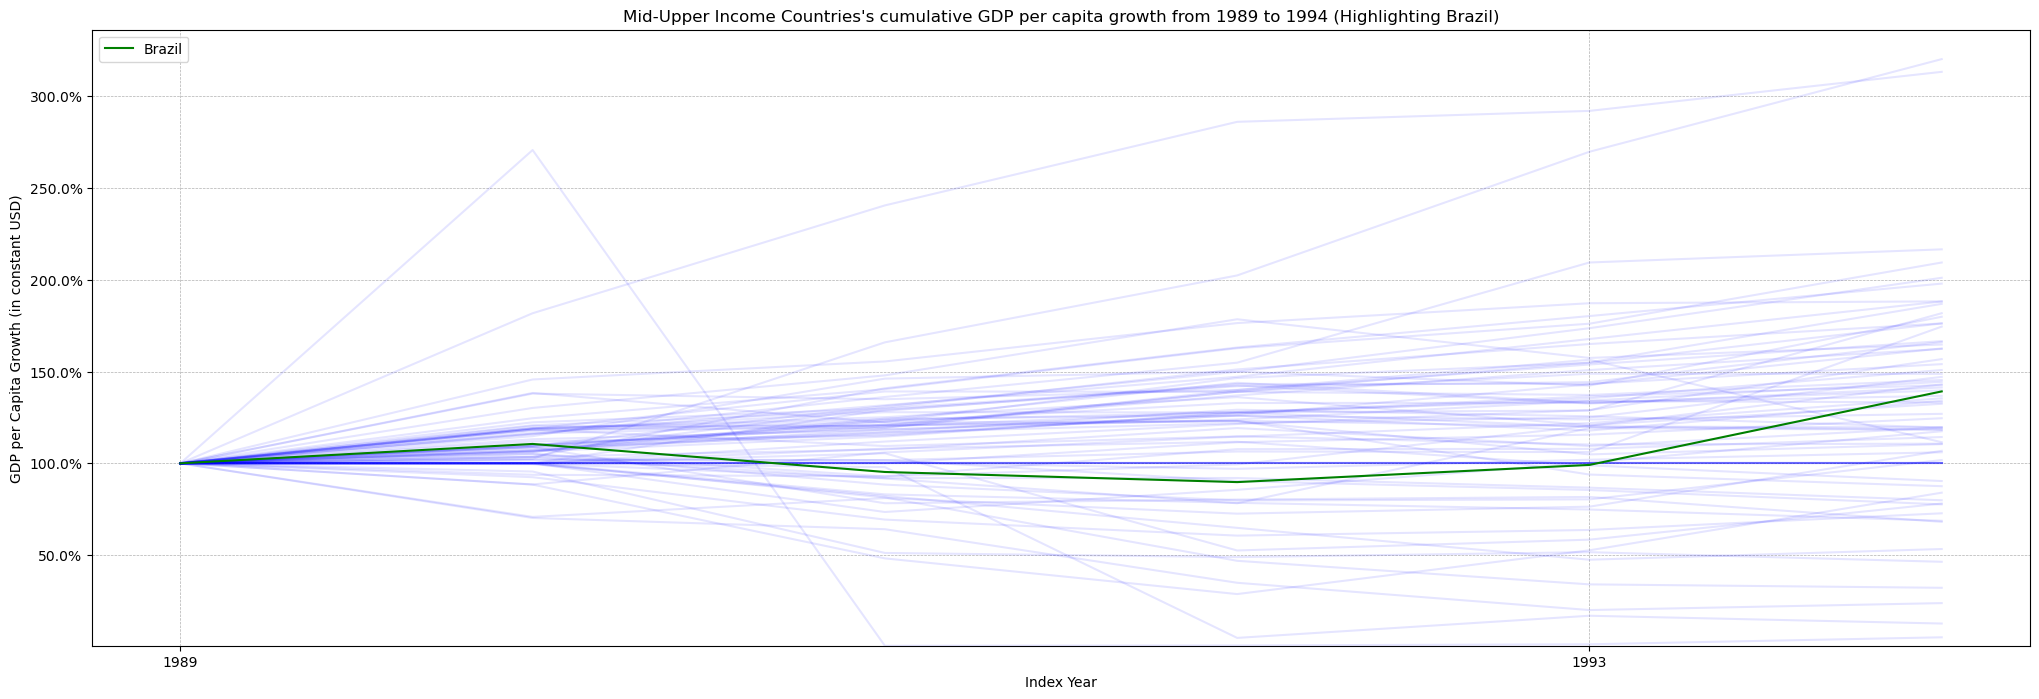

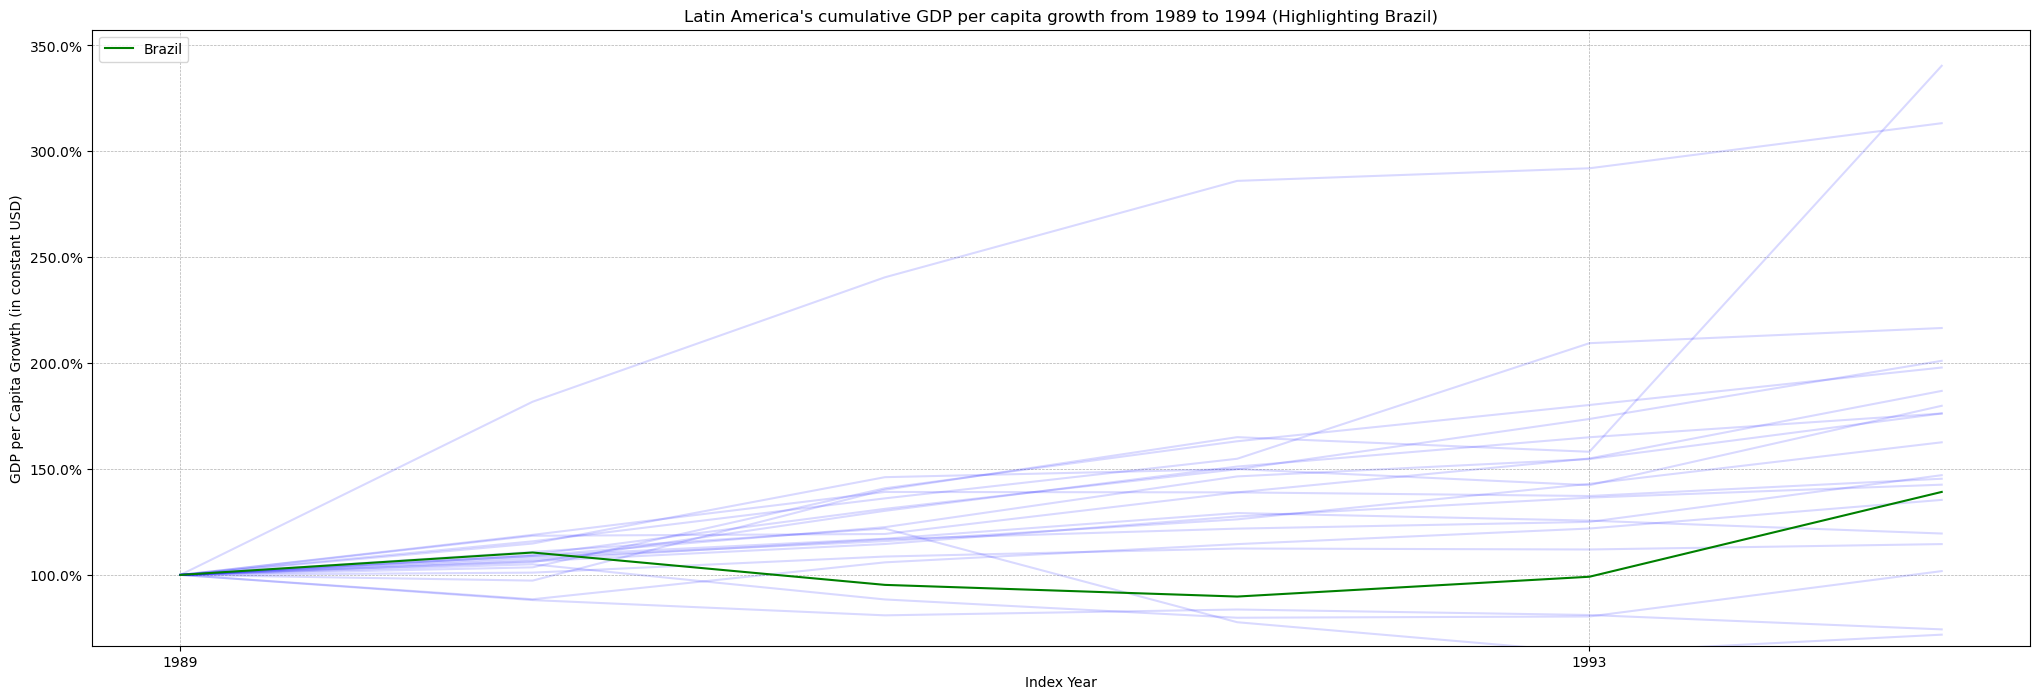

In [21]:
plotCumulativeGrowth(df_base, MidUpperIncome,"Mid-Upper Income Countries", 1989, 1994, xOffSet = 0, alpha = 0.1)
plotCumulativeGrowth(df_base, LatAm, "Latin America", 1989, 1994, xOffSet = 0)

### FHC: 1995 ~2002

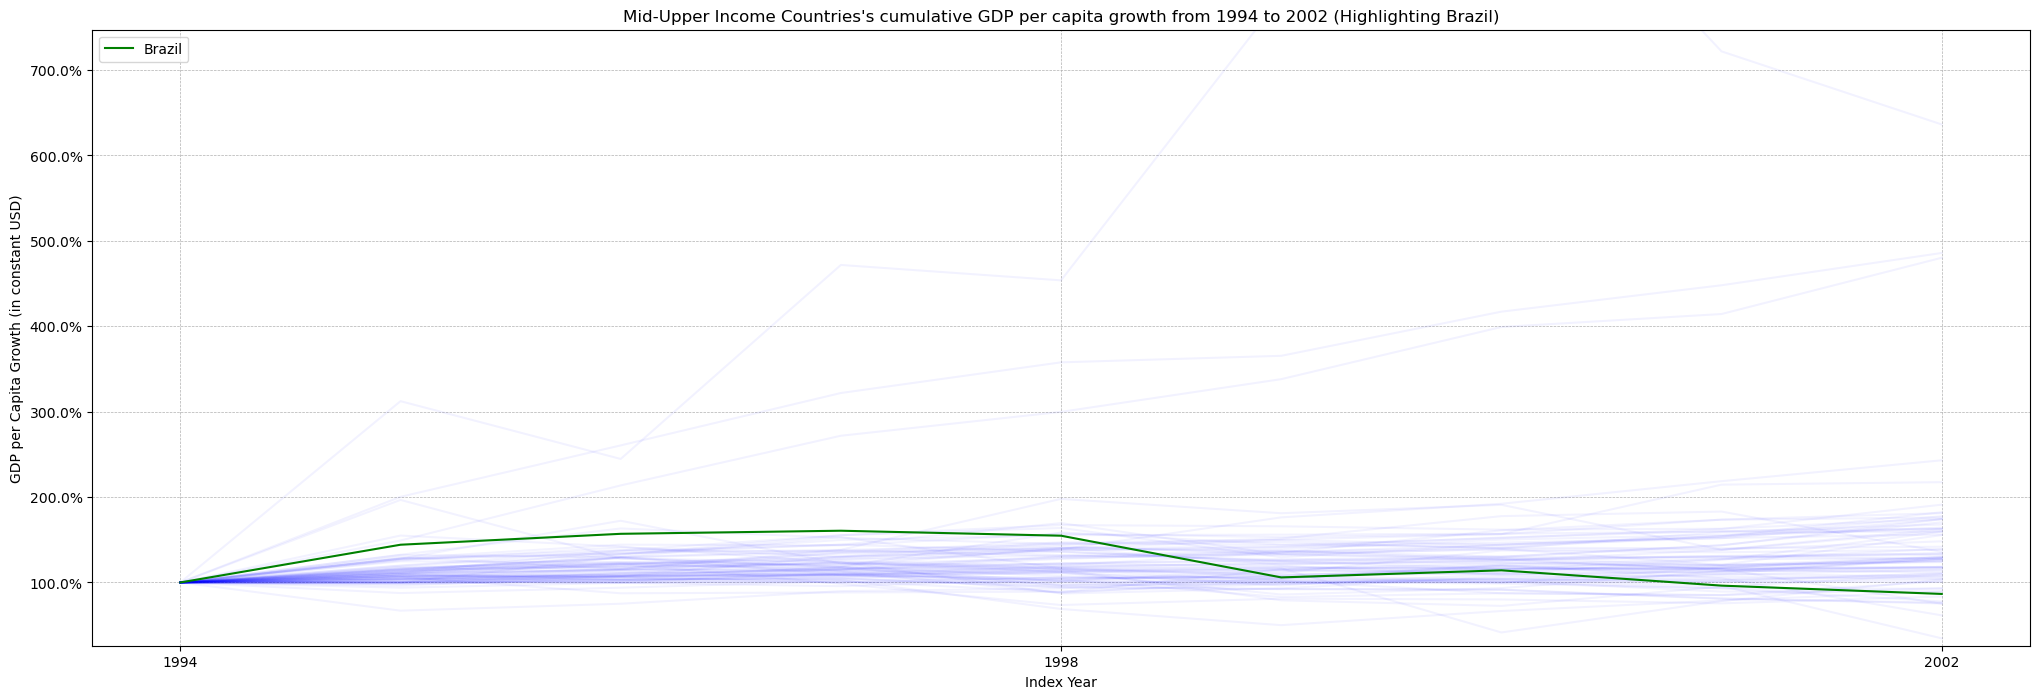

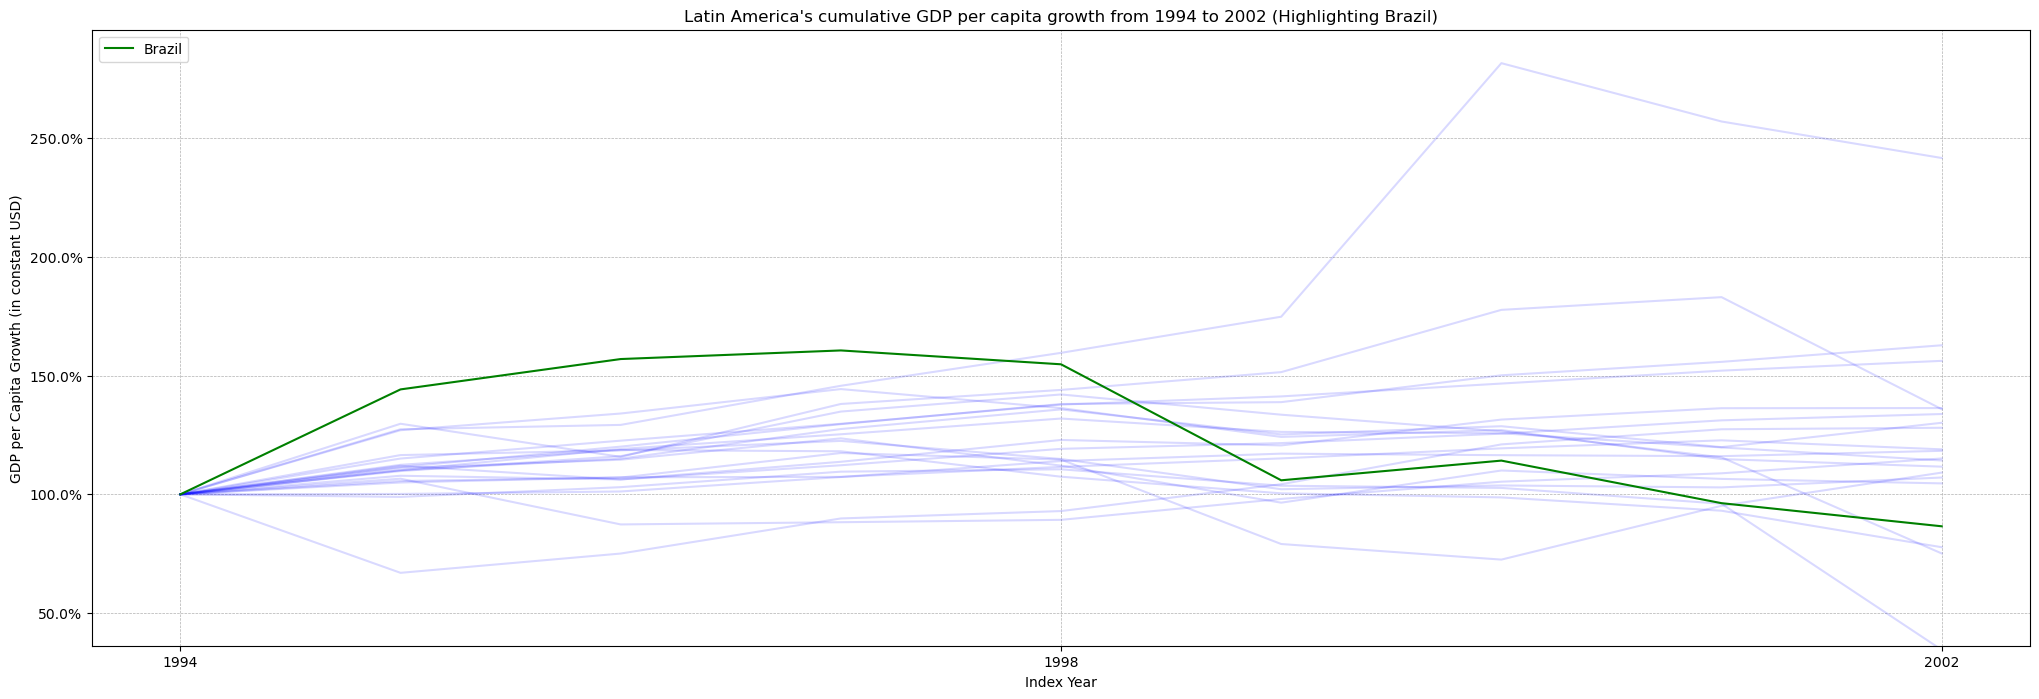

In [28]:
plotCumulativeGrowth(df_base, MidUpperIncome,"Mid-Upper Income Countries", 1994, 2002, xOffSet = 0, alpha = 0.05, yScale = 0.75)
plotCumulativeGrowth(df_base, LatAm, "Latin America", 1994, 2002, xOffSet = 0)

### Lula: 2003 ~ 2010

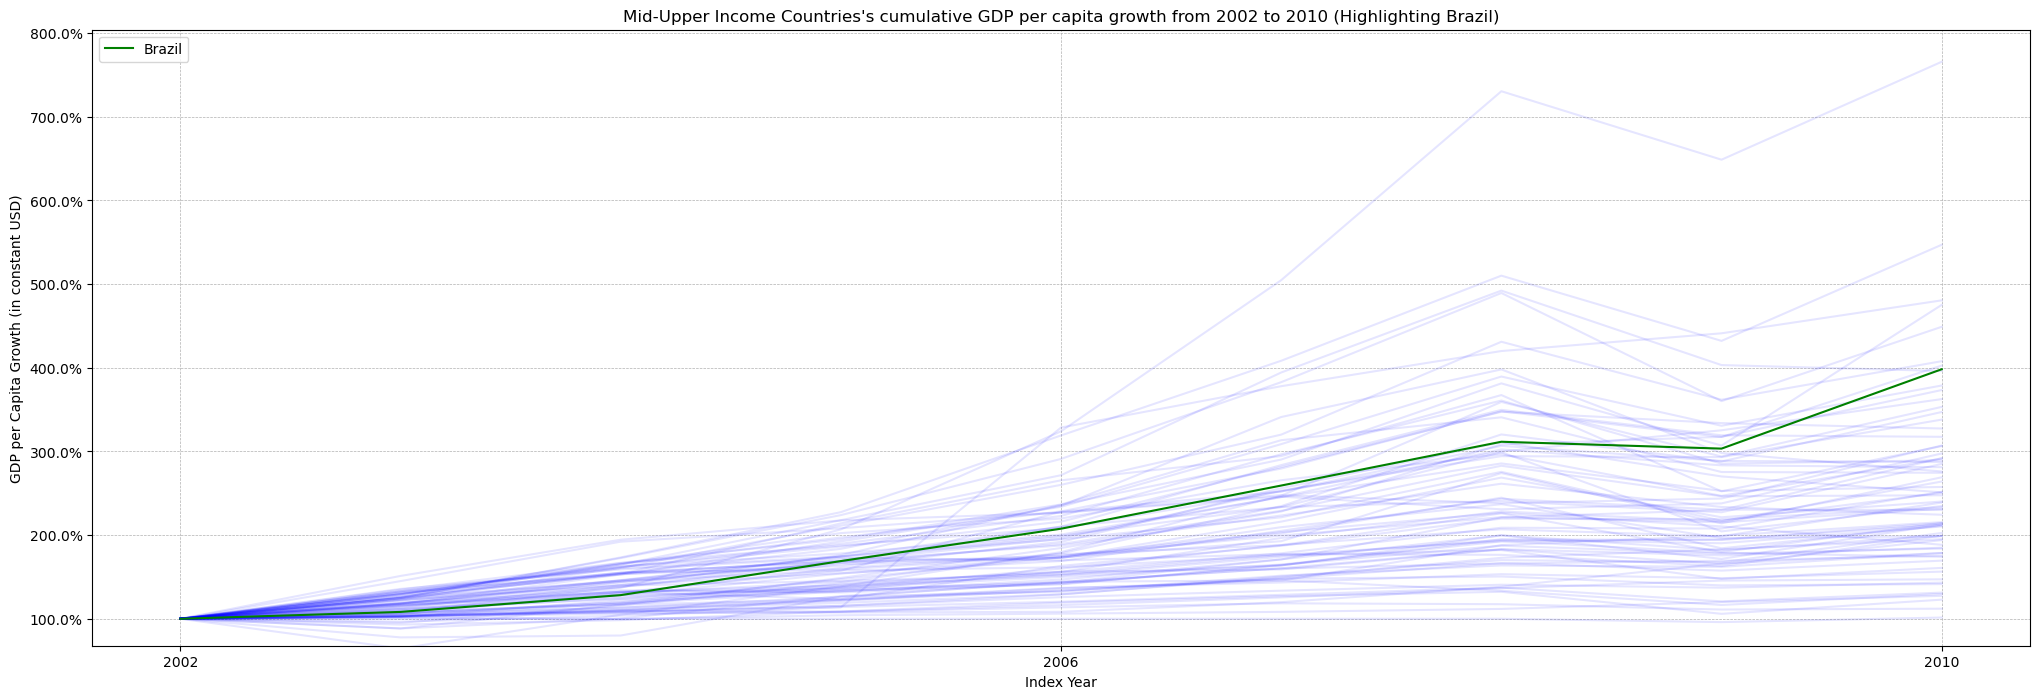

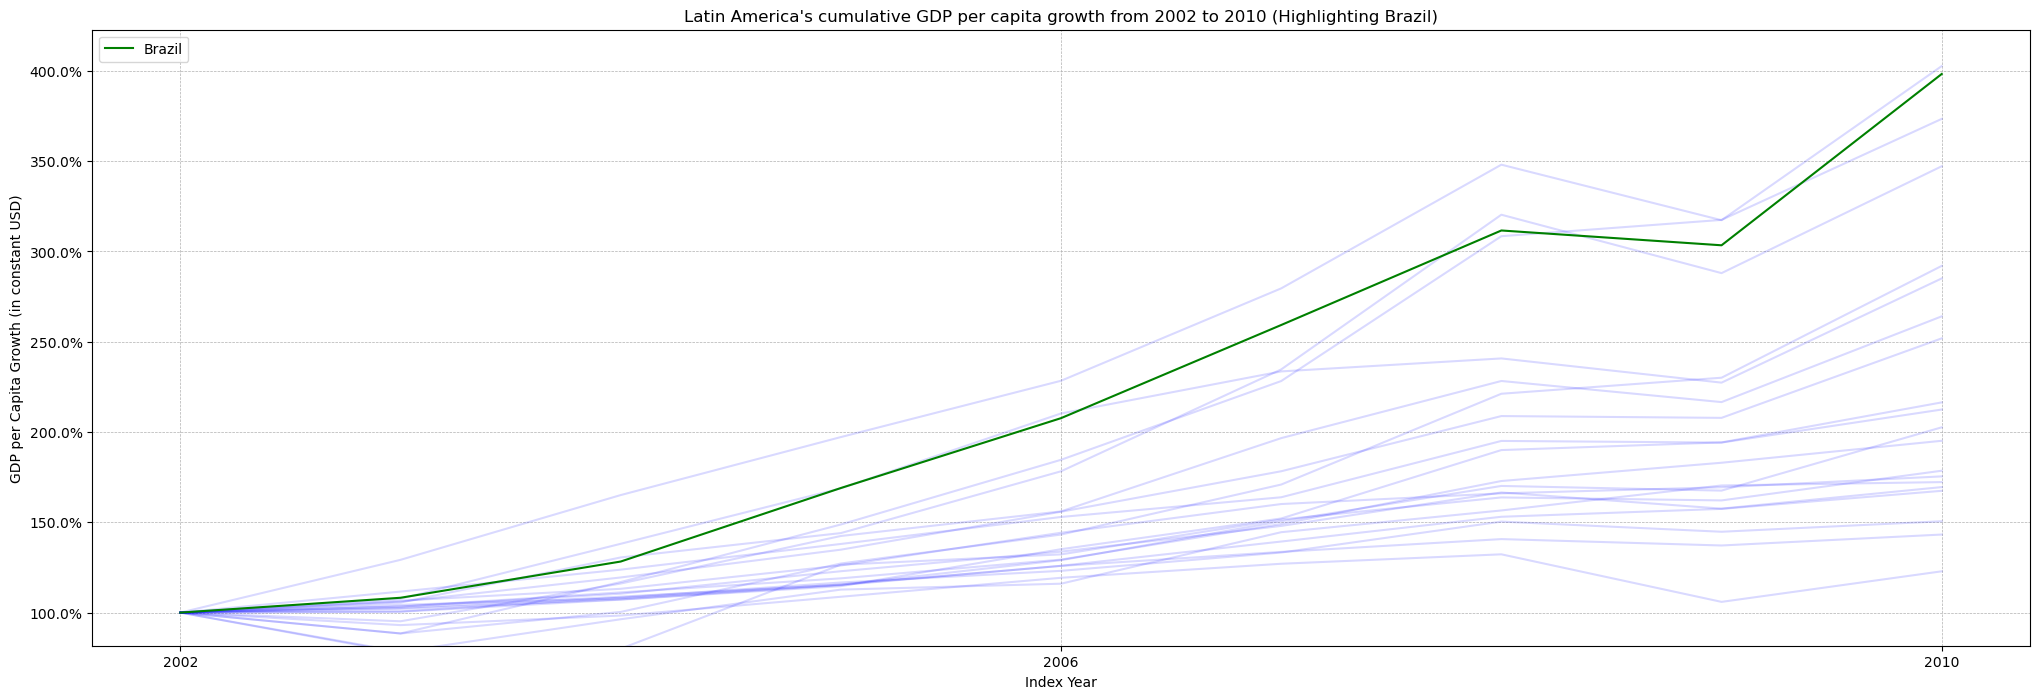

In [23]:
plotCumulativeGrowth(df_base, MidUpperIncome,"Mid-Upper Income Countries", 2002, 2010, xOffSet = 0, alpha = 0.05)
plotCumulativeGrowth(df_base, LatAm, "Latin America", 2002, 2010, xOffSet = 0)

### Dilma: 2011 ~ 2016

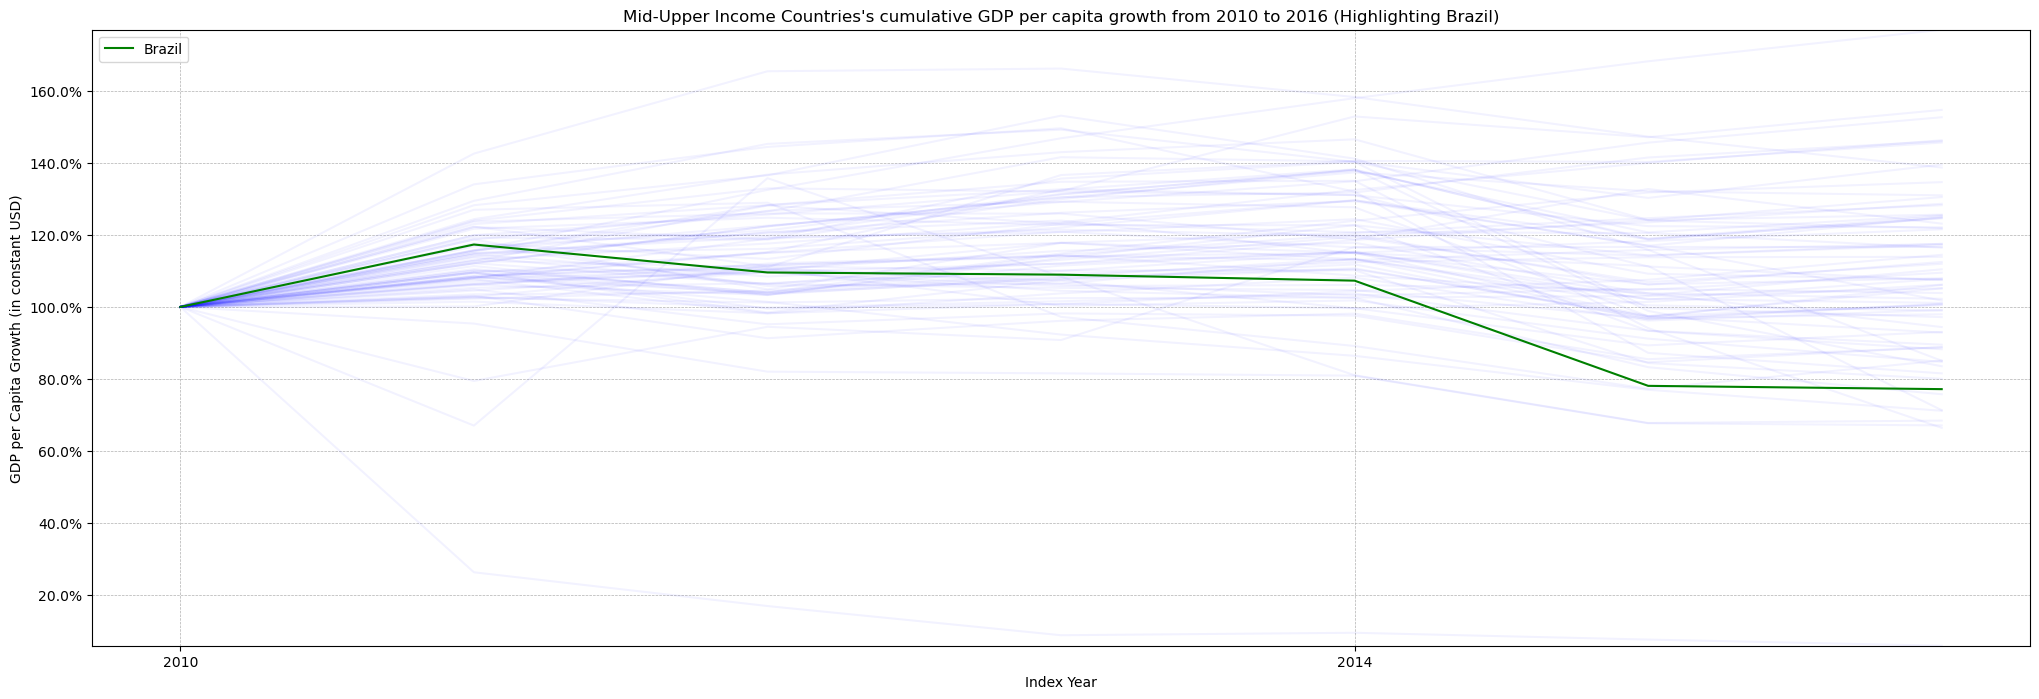

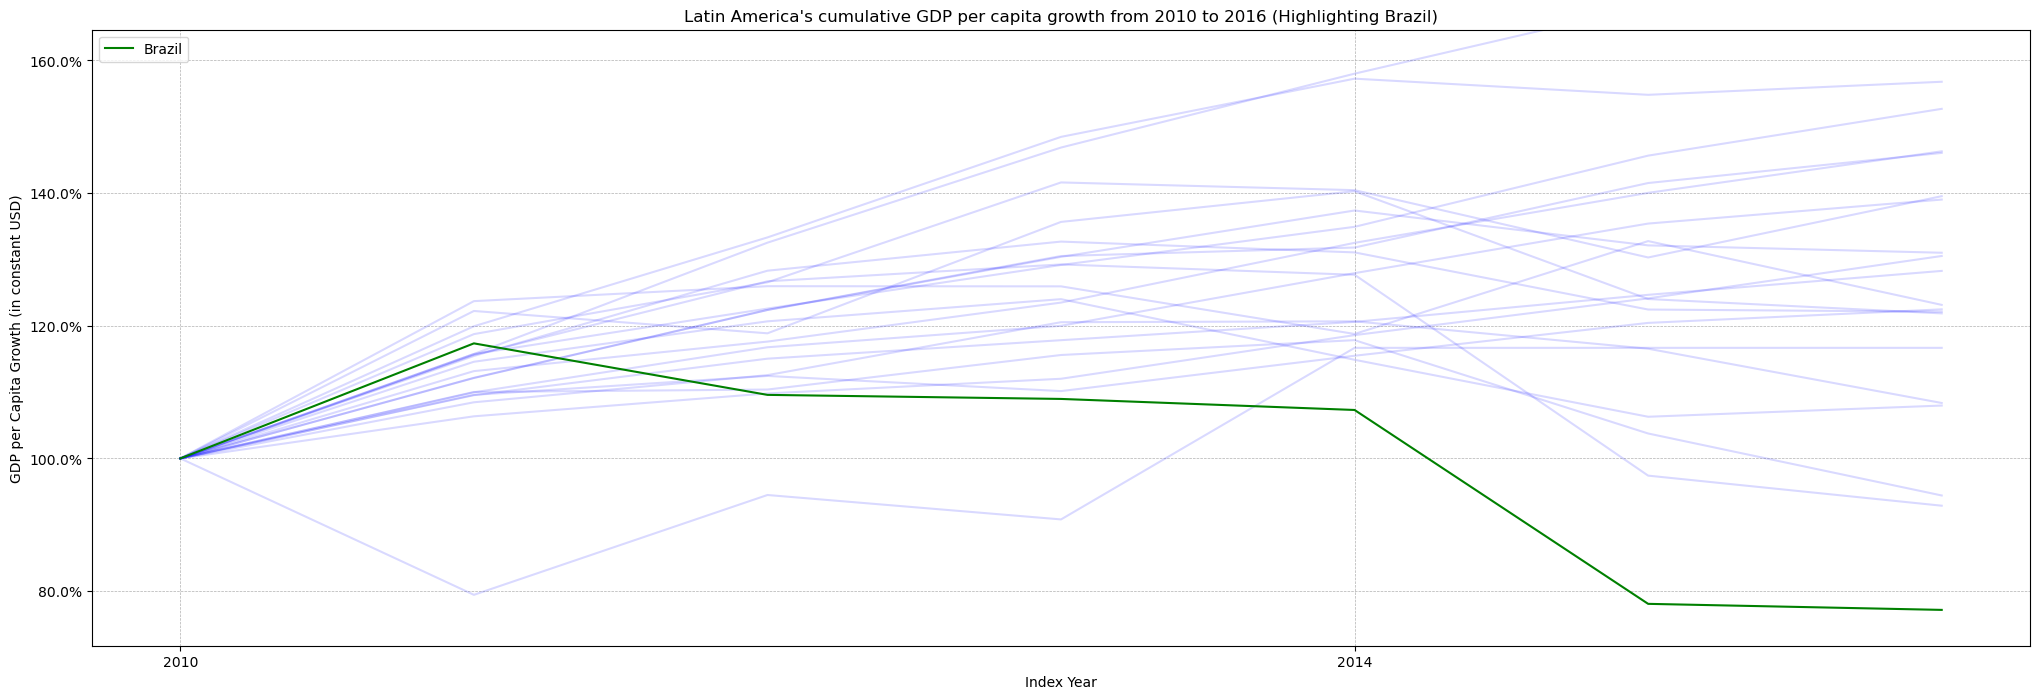

In [41]:
plotCumulativeGrowth(df_base, MidUpperIncome,"Mid-Upper Income Countries", 2010, 2016, xOffSet = 0, alpha = 0.05, yScale = 1)
plotCumulativeGrowth(df_base, LatAm, "Latin America", 2010, 2016, xOffSet = 0, yScale = 0.93)

### Temer: 2016 ~ 2018

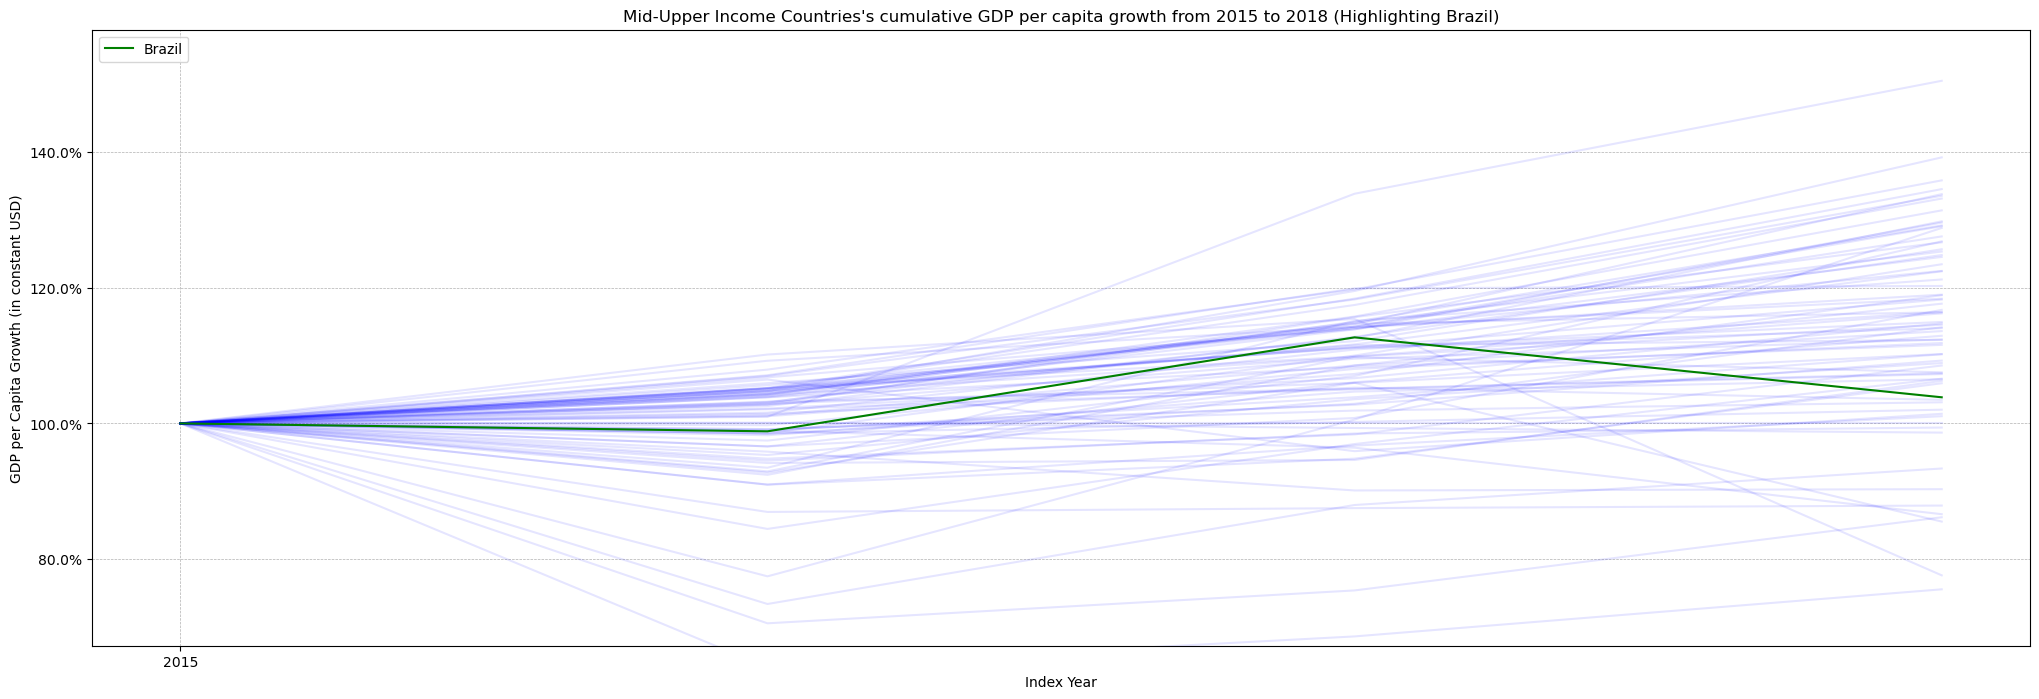

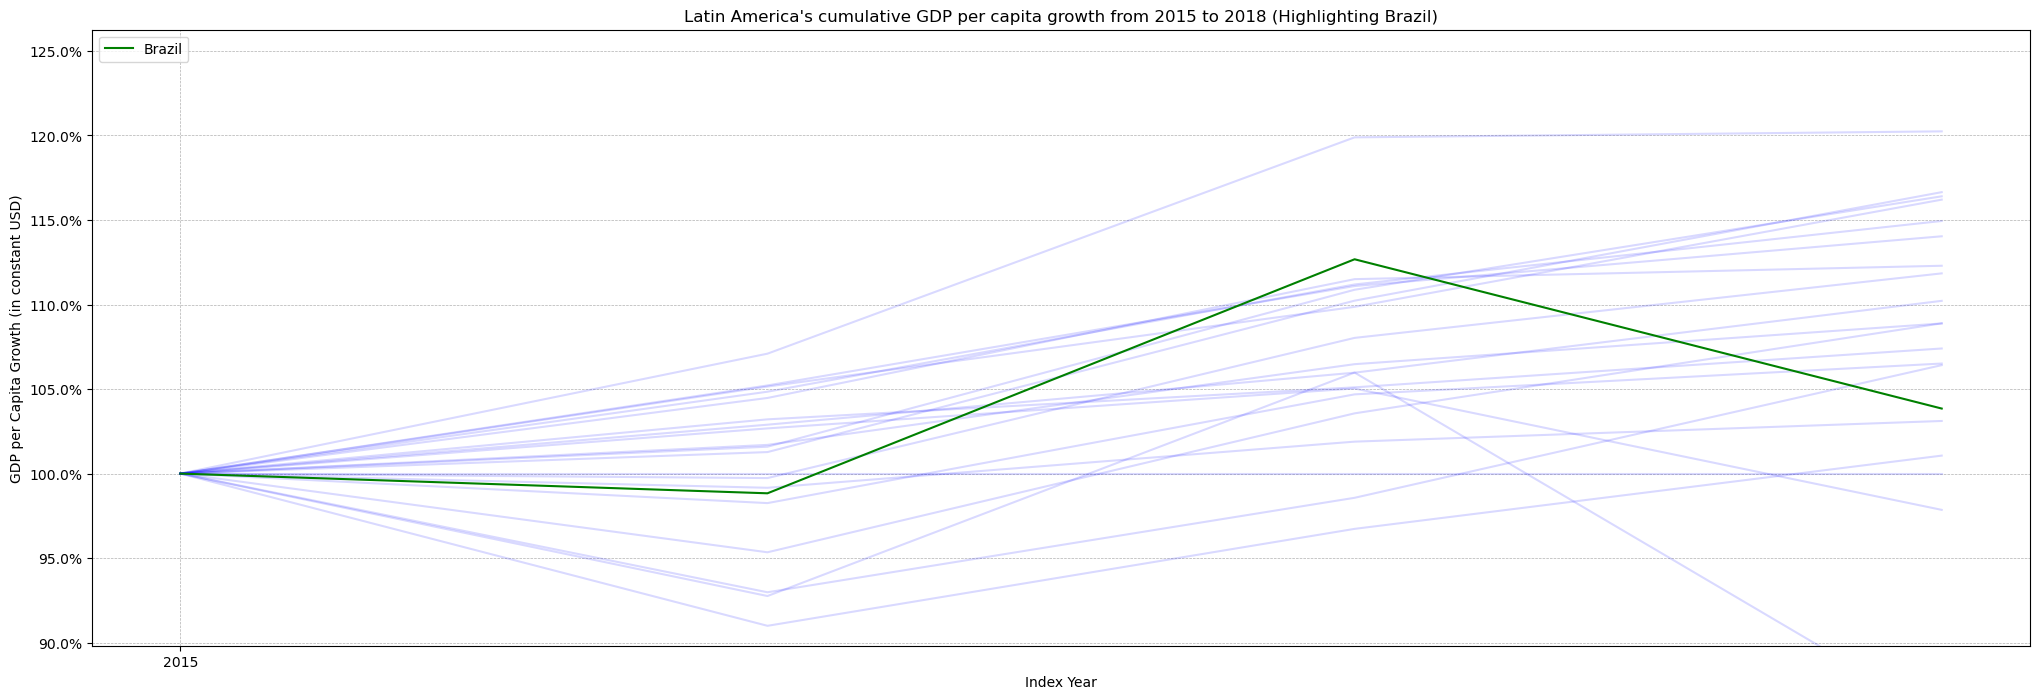

In [25]:
plotCumulativeGrowth(df_base, MidUpperIncome,"Mid-Upper Income Countries", 2015, 2018, xOffSet = 0, alpha = 0.1)
plotCumulativeGrowth(df_base, LatAm, "Latin America", 2015, 2018, xOffSet = 0)

### Bolsonaro: 2019 ~ 2022

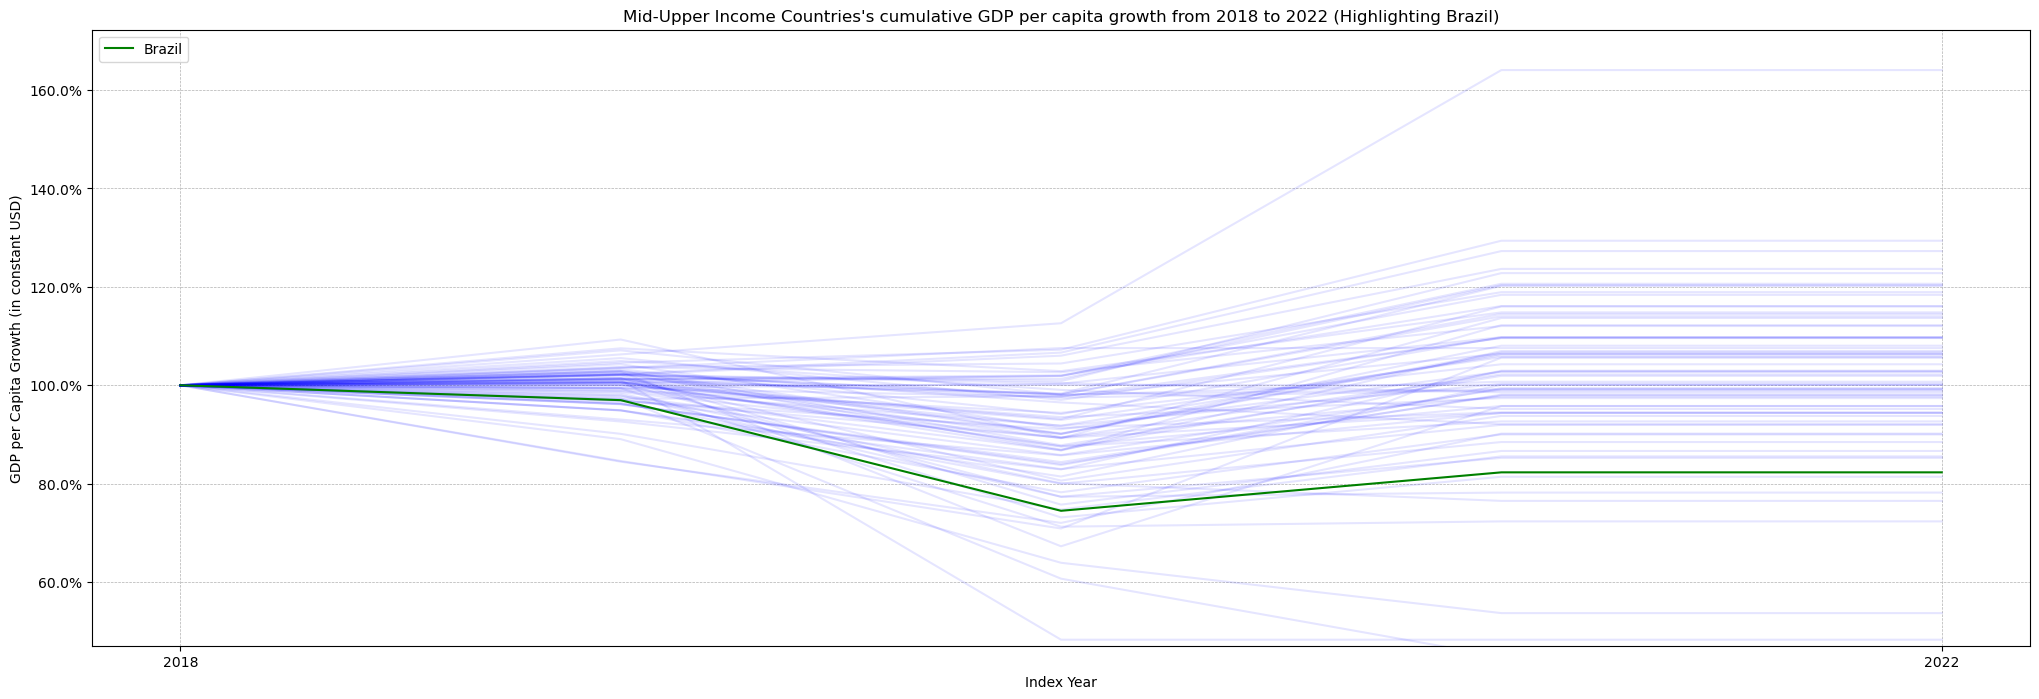

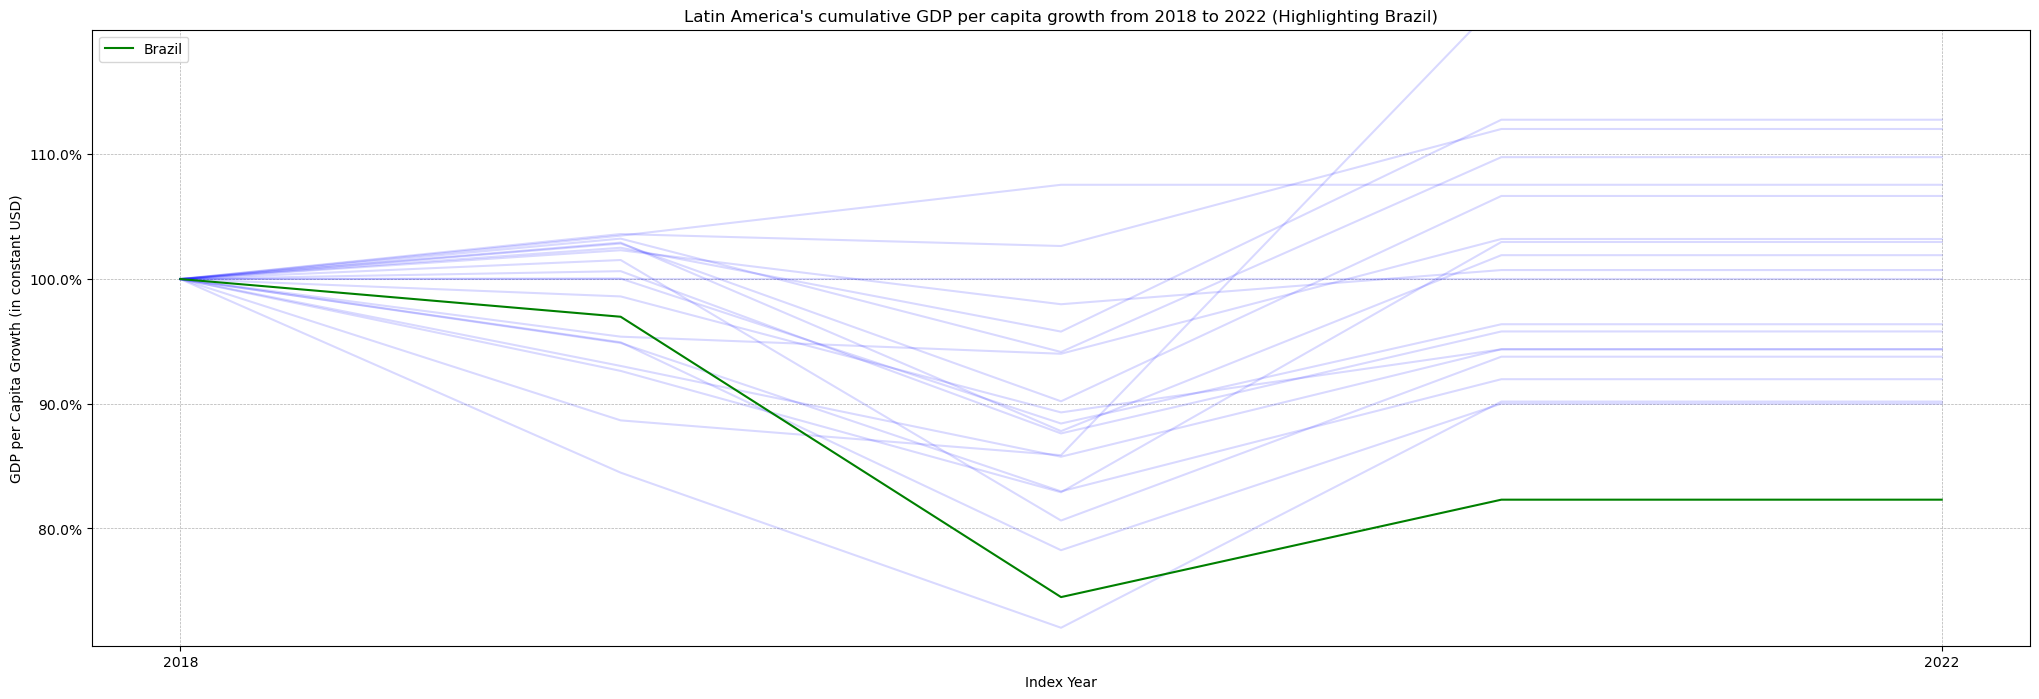

In [44]:
plotCumulativeGrowth(df_base, MidUpperIncome,"Mid-Upper Income Countries", 2018, 2022, xOffSet = 0, alpha = 0.1)
plotCumulativeGrowth(df_base, LatAm, "Latin America", 2018, 2022, xOffSet = 0, yScale = 0.98)